In [54]:
#import useful libraries for analysis and modeling
import pandas as pd
import numpy as np
from sklearn import tree
from scipy import stats
import os
import pickle
import sys
import tempfile
import math
# import matplotlib as mpl
# import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.tree import export_graphviz, DecisionTreeClassifier
pd.options.mode.chained_assignment = None
from IPython.display import display, HTML
import warnings
import json
from matplotlib import cm  # color map
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
import copy as cp
import shap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, DistanceMetric
from sklearn.preprocessing import scale
from sklearn.datasets import load_iris, load_wine
from matplotlib import pyplot as plt
import colorcet as cc
from sklearn.covariance import EllipticEnvelope 
#
from sklearn.cluster import OPTICS
from sklearn.cluster import DBSCAN
from sklearn.cluster import HDBSCAN
from sklearn.cluster import AgglomerativeClustering
import gower
from scipy.spatial.distance import hamming

# Filter all warnings
warnings.filterwarnings("ignore")


In [55]:
classes = ['normal', 'scanning', 'ddos', 'injection', 'password', 'xss',
       'dos', 'mitm', 'ransomware', 'backdoor']

classes_df = pd.DataFrame(classes, columns=['class'])

# list of all extracted features
# feats_all = ["ip.len","ip.ttl","tcp.flags.syn","tcp.flags.ack","tcp.flags.push","tcp.flags.fin","tcp.flags.rst",\
#             "tcp.flags.ece","ip.proto","srcport","dstport","ip.hdr_len","tcp.window_size_value","tcp.hdr_len","udp.length",\
#             "Min Packet Length","Max Packet Length","Packet Length Mean","Packet Length Total","UDP Len Min","UDP Len Max",\
#                 "Flow IAT Min","Flow IAT Max","Flow IAT Mean","Flow Duration",\
#                     "SYN Flag Count","ACK Flag Count","PSH Flag Count","FIN Flag Count","RST Flag Count","ECE Flag Count"]

# list of easy to compute online features - without means
feats_easy = ["ip.len","ip.ttl","tcp.flags.syn","tcp.flags.ack","tcp.flags.push","tcp.flags.fin","tcp.flags.rst",\
            "tcp.flags.ece","ip.proto","srcport","dstport","tcp.window_size_value","tcp.hdr_len","udp.length",\
            "Min Packet Length","Max Packet Length","Packet Length Total",\
                "Flow IAT Min","Flow IAT Max","Flow Duration","SYN Flag Count","ACK Flag Count",\
                    "PSH Flag Count","FIN Flag Count","RST Flag Count","ECE Flag Count"]

# feats_no_time = ["ip.len","ip.ttl","tcp.flags.syn","tcp.flags.ack","tcp.flags.push","tcp.flags.fin","tcp.flags.rst",\
#             "tcp.flags.ece","ip.proto","srcport","dstport","tcp.window_size_value","tcp.hdr_len","udp.length",\
#             "Min Packet Length","Max Packet Length","Packet Length Total",\
#                 "SYN Flag Count","ACK Flag Count","PSH Flag Count","FIN Flag Count","RST Flag Count","ECE Flag Count"]


feats_all = ["ip.len","ip.ttl","tcp.flags.syn","tcp.flags.ack","tcp.flags.push","tcp.flags.fin","tcp.flags.rst",\
            "tcp.flags.ece","ip.proto","srcport","dstport","tcp.window_size_value","tcp.hdr_len","udp.length",\
            "Min Packet Length","Max Packet Length","Packet Length Total",\
                "SYN Flag Count","ACK Flag Count","PSH Flag Count","FIN Flag Count","RST Flag Count","ECE Flag Count"]

In [108]:
def convert_str_to_dict(field_value):
    return json.loads(field_value.replace("\'", "\""))

""" Function to save trained model to pickle"""
def save_model(RF, filename):
    pickle.dump(RF, open(filename, 'wb'))

def get_test_labels(IoT_Test, classes, classes_df):
    array_of_indices = []
    unique_labels = IoT_Test["Label_NEW"].unique()
    # unique_labels = IoT_Test["Label"].unique()
    for lab in unique_labels:
        index = classes_df[classes_df['class'] == lab].index.values[0]
        array_of_indices.append(index)
    return unique_labels, array_of_indices

"""
Function to Fit model based on optimal values of depth and number of estimators and use it
to compute feature importance for all the features.
"""
def get_feature_importance(depth, n_tree, max_leaf, X_train, y_train, weight_of_samples,columns):
    
    # rf_opt = RandomForestClassifier(max_depth = depth, n_estimators = n_tree, max_leaf_nodes=max_leaf, random_state=42, bootstrap=False,n_jobs=10)
    rf_opt = RandomForestClassifier(max_depth = depth, n_estimators = n_tree, random_state=42, bootstrap=False,n_jobs=10)
    rf_opt.fit(X_train, y_train, sample_weight=weight_of_samples)
    feature_importance = pd.DataFrame(rf_opt.feature_importances_)
    # feature_importance.index = X_train.columns
    feature_importance.index = columns
    feature_importance = feature_importance.sort_values(by=list(feature_importance.columns),axis=0,ascending=False)
    
    return feature_importance

"""
Function to Fit model based on optimal values of depth and number of estimators and feature importance
to find the fewest possible features to exceed the previously attained score with all selected features
"""
def get_fewest_features(depth, n_tree, max_leaf, importance):    
    sorted_feature_names = importance.index
    # print('sorted_feature_names: ', sorted_feature_names)
    features = []
    for f in range(1,len(sorted_feature_names)+1):
        features.append(sorted_feature_names[0:f])
    return features

def get_result_scores(classes, cl_report):
    precision=[]
    recall=[]
    f1_score=[]
    supports=[]
    for a_class in classes:
        precision.append(cl_report[a_class]['precision'])
        recall.append(cl_report[a_class]['recall'])
        f1_score.append(cl_report[a_class]['f1-score'])
        supports.append(cl_report[a_class]['support'])
    return precision, recall, f1_score, supports

"""
Function to calculate the score of the model
"""
def get_scores(classes, depth, n_tree, feats, max_leaf, X_train, y_train, X_test, y_test, unique_labels,array_of_indices,weight_of_samples):
    # model = RandomForestClassifier(max_depth=depth, n_estimators = n_tree, max_leaf_nodes=max_leaf, n_jobs=10,
    #                                 random_state=42, bootstrap=False)
    
    model = RandomForestClassifier(n_estimators = n_tree, max_leaf_nodes=max_leaf, n_jobs=10,
                                    random_state=42, bootstrap=False)
    
    
    print(model)
    
    model.fit(X_train[feats], y_train, sample_weight=weight_of_samples)
    y_pred = model.predict(X_test[feats])

    y_test = [int(label) for label in y_test.values]
    y_pred = [int(label) for label in y_pred]

    class_report = classification_report(y_test, y_pred, labels=unique_labels, target_names=array_of_indices, output_dict = True)

    macro_score = class_report['macro avg']['f1-score']
    weighted_score = class_report['weighted avg']['f1-score']

    return model, class_report, macro_score, weighted_score, y_pred


def get_x_y_flow(Dataset, feats, classes):    
    X = Dataset[feats]
    y = Dataset['Label_NEW'].replace(classes, range(len(classes)))
    y_all = Dataset['Label']
    sample_nature = Dataset['sample_nature']
    return X, y, sample_nature, y_all

def get_x_y_flow_binary(Dataset, feats, classes):    
    X = Dataset[feats]
    y = Dataset['Label_Binary'].replace(classes, range(len(classes)))
    sample_nature = Dataset['sample_nature']
    return X, y, sample_nature

"""
Function to calculate the score of the model in terms of Flow-Level metric
"""

def expand_rows_and_get_scores(y_true, y_pred, y_test_ALL, sample_nature, multiply, test_flow_pkt_cnt, test_flow_IDs, unique_labels, array_of_indices):
    expanded_y_true = []
    expanded_y_pred = []
    expanded_y_true_all = []
    #
    expanded_weights = []
    expanded_flow_IDs = []
    
    for true_label, pred_label, y_test_ALL_label, nature, mult, pkt_cnt, f_id in zip(y_true, y_pred, y_test_ALL, sample_nature, multiply, test_flow_pkt_cnt, test_flow_IDs):
        if nature == 'flw':
            expanded_y_true.extend([true_label] * (mult+1))
            expanded_y_pred.extend([pred_label] * (mult+1))
            expanded_y_true_all.extend([y_test_ALL_label] * (mult+1))
            #
            expanded_weights.extend([1/pkt_cnt] * (mult+1))
            expanded_flow_IDs.extend([f_id]* (mult+1))
        else:
            expanded_y_true.append(true_label)
            expanded_y_pred.append(pred_label)
            expanded_y_true_all.append(y_test_ALL_label)
            #
            expanded_weights.append(1/pkt_cnt)
            expanded_flow_IDs.append(f_id)
    
    # report = classification_report(expanded_y_true, expanded_y_pred)
    
    num_samples = len(expanded_y_true)

    expanded_y_true = [int(label) for label in expanded_y_true]
    expanded_y_pred = [int(label) for label in expanded_y_pred]
    # labels=array_of_indices, target_names=unique_labels,
    cl_report_PL = classification_report(expanded_y_true, expanded_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True)
    macro_f1_PL = cl_report_PL['macro avg']['f1-score']
    weighted_f1_PL = cl_report_PL['weighted avg']['f1-score']
    try:
        micro_f1_PL = cl_report_PL['micro avg']['f1-score']
    except:
        micro_f1_PL = cl_report_PL['accuracy']
    ####
    
    c_report_FL =  classification_report(expanded_y_true, expanded_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True,sample_weight=expanded_weights)
    
    macro_f1_FL = c_report_FL['macro avg']['f1-score']
    weighted_f1_FL = c_report_FL['weighted avg']['f1-score']
    try:
        micro_f1_FL = c_report_FL['micro avg']['f1-score']
    except:
        micro_f1_FL = c_report_FL['accuracy']
    
    return num_samples, macro_f1_PL, weighted_f1_PL, micro_f1_PL, cl_report_PL, macro_f1_FL, weighted_f1_FL, micro_f1_FL, c_report_FL, expanded_y_true, expanded_y_pred, expanded_weights, expanded_y_true_all

def compute_flow_pkt_scores(y_pred, y_test, sample_nature,unique_labels,array_of_indices):

    # Create a data frame with the three columns
    df = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test, 'sample_nature': sample_nature})
    
    # Split the data frame into two data frames based on sample_nature
    pkt_df = df[df['sample_nature'] == 'pkt']
    flw_df = df[df['sample_nature'] == 'flw']
    
    # Compute macro and weighted F1 scores for pkt_df
    pkt_df_y_true = [int(label) for label in pkt_df['y_test'].values]
    pkt_df_y_pred = [int(label) for label in pkt_df['y_pred']]

    # labels=array_of_indices, target_names=unique_labels,
    pkt_macro_f1 = classification_report(pkt_df_y_true, pkt_df_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True)['macro avg']['f1-score']
    pkt_weighted_f1 = classification_report(pkt_df_y_true, pkt_df_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True)['weighted avg']['f1-score']
    
    # Compute macro and weighted F1 scores for flw_df
    flw_df_y_true = [int(label) for label in flw_df['y_test'].values]
    flw_df_y_pred = [int(label) for label in flw_df['y_pred']]

    flw_macro_f1 = classification_report(flw_df_y_true, flw_df_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True)['macro avg']['f1-score']
    flw_weighted_f1 = classification_report(flw_df_y_true, flw_df_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True)['weighted avg']['f1-score']

    return pkt_macro_f1, pkt_weighted_f1, flw_macro_f1, flw_weighted_f1

In [57]:
# Define a function to check the conditions and assign values
def assign_sample_nature(row):
    if (row["Min Packet Length"] == -1 and
        row["Max Packet Length"] == -1 and
        row["Flow IAT Min"] == -1 and
        row["Flow IAT Max"] == -1):
        return "pkt"
    else:
        return "flw"

In [58]:
def read_csv(csv_file_names):
    csv_files = []
    for f_name in csv_file_names:
        df = pd.read_csv(f_name, sep=';')
        csv_files.append(df)
        
    return pd.concat(csv_files)

In [59]:
def plot_line(x_axis_values, y_axis_values, labels, x_title, y_title, fig_title):
    fig = plt.figure(figsize = (15, 5))
    colors= {'#6E7E99', '#ffbb78','#8A9961','#1f77b4', '#E06B5A', '#A95C68'}
    # for x_axis_val, y_axis_val, label, color in zip(x_axis_values, y_axis_values, labels, colors):
    #     plt.plot(x_axis_val, y_axis_val, label=label, color=color, linewidth=1.5)
    
    for x_axis_val, y_axis_val, color in zip(x_axis_values, y_axis_values, colors):
        plt.plot(x_axis_val, y_axis_val, 'g*-', color=color, linewidth=1.5, markersize=4)
    plt.plot(x_axis_val, [0.7 for i in range(0, len(x_axis_val))], color='gray', linestyle='--', lw=1)
    plt.plot(x_axis_val, [0.5 for i in range(0, len(x_axis_val))], color='gray', linestyle='--', lw=1)
    plt.xlabel(x_title, fontsize=15, labelpad=13)
    plt.ylabel(y_title, fontsize=15, labelpad=14)
    plt.xticks(rotation=90)
    plt.title(fig_title)
    plt.legend()
    plt.show()

In [60]:
#### PCFI - Per Class Feature Importance ####
def f_gini(v):
    p = v/v.sum()
    return np.multiply(p, 1-p).sum()

def f_entropy(v):
    return sps.entropy(pk=v)

def f_misclassification(v):
    p = v/v.sum()
    
def calcImportanceMatrix(rf_clf):
    """
    Calculates the importance matrix of predictors for each class.

    Arguments:
        rf_clf - The random forest classifier to calculate the importance matrix for.
        Must (?) be a RandomForestClassifier object. EXTENSIBLE TO ANY DECISION TREE CLASSIFIER FROM sklearn.tree?

    Returns:
        importance_matrix - The importance matrix with the importance of each predictor in predicting a class.
        A n by m numpy array.

    """

    # get the number of classes being predicted by the random forest
    classes = rf_clf.classes_
    n_classes = len(classes)

    # init storage for the predictor importances by classes by trees
    importance_matrix = []

    #dec_tree = rf_clf.estimators_[0]
    ### For every estimator:
    first_for_count = 0
    for dec_tree in rf_clf.estimators_:
        first_for_count = first_for_count + 1
        # get the criterion used to measure impurity
        criterion = dec_tree.get_params()['criterion']
        if criterion == 'gini':
            f_impurity = f_gini
        elif criterion == 'entropy':
            f_impurity = f_entropy
        elif criterion == 'misclassification':
            f_impurity = f_misclassification
        else:
            f_impurity = 0
            print('Unassigned impurity measure')

        # get the number of features and nodes in the tree
        feature = dec_tree.tree_.feature
        n_features = dec_tree.tree_.n_features
        n_nodes = dec_tree.tree_.__getstate__()['node_count']
        nodes = dec_tree.tree_.__getstate__()['nodes']
        parent_node_ind = -np.ones(shape=n_nodes, dtype='<i8')
        #parent_node_ind[0] = n_nodes + 1
        #print(parent_node_ind)
        for par_ind,node in enumerate(nodes):
            if node[0] != -1:
                parent_node_ind[node[0]] = par_ind
            if node[1] != -1:
                parent_node_ind[node[1]] = par_ind
        #print(parent_node_ind)

        # identify the leaves of the tree
        is_leaves = np.array([node[0]==-1 and node[1]==-1 for node in nodes])
        
        leaves_index = np.nonzero(is_leaves)[0]

        values_sorted = dec_tree.tree_.__getstate__()['values']
        #print ('nodes', nodes, len(nodes), len(values_sorted[:,0,:]))
        node_pred = np.argmax(values_sorted[:,0,:], axis=1)
        # print('NODE PRED:', node_pred)
        leaves_class_index = node_pred[is_leaves]
        #for par_ind,node in enumerate(nodes):
        #    print(par_ind,parent_node_ind[par_ind],is_leaves[par_ind],node,
        #          values_sorted[par_ind], values_sorted[par_ind].sum())
        node_unvisited = np.ones((n_classes, n_nodes), dtype=bool)
        tree_importances = np.zeros((n_classes, n_features))
        second_for_count = 0
        for leaf_i,leaf_c_i in zip(leaves_index,leaves_class_index):
            second_for_count = second_for_count + 1
            current_i = parent_node_ind[leaf_i]
            # print('START from leaf ', leaf_i, 'with class ', leaf_c_i)
            #print('whose parent is ', current_i)
            # walk the tree and calculate the importance of the predictor
            third_for_count = 0
            while current_i != -1 and node_unvisited[leaf_c_i,current_i]:
                third_for_count = third_for_count + 1
                current_node = nodes[current_i]
                left_node = nodes[current_node['left_child']]
                right_node = nodes[current_node['right_child']]
                current_feature = current_node['feature']
                
                current_values = values_sorted[current_i,0,:]
                left_values = values_sorted[current_node['left_child'],0,:]
                right_values = values_sorted[current_node['right_child'],0,:]
                
                # print(leaves_class_index, current_values_class)
                current_values_class = np.array([
                    current_values[leaf_c_i],
                    current_values[np.arange(len(current_values)) != leaf_c_i].sum()
                ])
                left_values_class = np.array([
                    left_values[leaf_c_i],
                    left_values[np.arange(len(left_values)) != leaf_c_i].sum()
                ])
                right_values_class = np.array([
                    right_values[leaf_c_i],
                    right_values[np.arange(len(right_values)) != leaf_c_i].sum()
                ])
                tree_importances[leaf_c_i,current_feature] += (
                        current_node['weighted_n_node_samples'] * f_impurity(current_values_class) -
                        left_node['weighted_n_node_samples'] * f_impurity(left_values_class) -
                        right_node['weighted_n_node_samples'] * f_impurity(right_values_class)
                        )
                ###
                node_unvisited[leaf_c_i,current_i] = False
                current_i = parent_node_ind[current_i]
                if third_for_count > 23:
                    print(first_for_count, second_for_count, third_for_count)
                # print('next current is ', current_i)
        # print(tree_importances.shape)
        importance_matrix.append(tree_importances/nodes[0]['weighted_n_node_samples'])
        # print(importance_matrix)
    # average the predictor importances for each class by all of the trees in the forest
    importance_matrix = np.mean(importance_matrix, axis = 0)
    #normalise importance over each class
    importance_matrix = (importance_matrix.T / np.sum(importance_matrix, axis=1)).T
    return(importance_matrix)

In [105]:
def analyze_model(npkts, depth, n_tree, max_leaves, feats, classes, classes_df):    

    # Load Train and Test data
    train_data = pd.read_csv("/home/nds-admin/ToN-IoT/data/train/train_"+str(npkts)+"_pkts.csv")
    test_data = pd.read_csv("/home/nds-admin/ToN-IoT/data/test/test_"+str(npkts)+"_pkts.csv")
    #
    flow_pkt_counts = pd.read_csv("/home/nds-admin/ToN-IoT/ToN_IoT_Test_Flow_PktCounts.csv")
    flow_pkt_counts_train = pd.read_csv("/home/nds-admin/ToN-IoT/ToN_IoT_Train_Flow_PktCounts.csv")

    flow_count_dict_train = flow_pkt_counts_train.set_index("Flow ID")["packet_counts"].to_dict()
    train_data["pkt_count"] = train_data["Flow ID"].map(flow_count_dict_train)

    # # Extract the count column values and assign them to the pkt_count column in test_data
    flow_count_dict = flow_pkt_counts.set_index("Flow ID")["packet_counts"].to_dict()
    test_data["pkt_count"] = test_data["Flow ID"].map(flow_count_dict)
    #
    all_minus_one = (test_data['Min Packet Length'] == -1) & (test_data['Max Packet Length'] == -1) & (test_data['Packet Length Mean'] == -1)
    # Assign values to the multiply column based on the conditions
    test_data['multiply'] = np.where(all_minus_one, 1, test_data['pkt_count'] - npkts)

    train_data = train_data.sample(frac=1, random_state=42)
    test_data  = test_data.sample(frac=1, random_state=42)

    train_data = train_data.dropna(subset=['srcport', 'dstport']) 
    test_data  = test_data.dropna(subset=['srcport', 'dstport'])

    
    # train_data = train_data[~train_data['Label'].isin(classes)]
    # test_data = test_data[~test_data['Label'].isin(classes)]
    
    ####
    train_data['Label_NEW'] = np.where((train_data['Label'].isin(classes)), train_data['Label'], 'Other')
    test_data['Label_NEW'] = np.where((test_data['Label'].isin(classes)), test_data['Label'], 'Other')
    # print(train_data['Label_NEW'].value_counts())
    # print(test_data['Label_NEW'].value_counts())
    ####

    test_labels, test_indices = get_test_labels(test_data, classes, classes_df)
    print("Num Labels: ", len(test_labels))
    # print("Index: ", test_indices)

    train_data['sample_nature'] = train_data.apply(assign_sample_nature, axis=1)
    test_data['sample_nature']  = test_data.apply(assign_sample_nature, axis=1)
    
    # train_data['weight'] = np.where(train_data['sample_nature'] == 'flw', npkts, 1)
    # weight_of_samples = list(train_data['weight'])
    
    train_data['weight'] = np.where(train_data['sample_nature'] == 'flw', (train_data['pkt_count'] - npkts + 1)/train_data['pkt_count'], 1/train_data['pkt_count'])
    weight_of_samples = list(train_data['weight'])

    # Get Variables and Labels
    y_multiply = test_data['multiply'].astype(int)
    test_flow_pkt_cnt = test_data['pkt_count'].to_list()
    test_flow_IDs = test_data['Flow ID'].to_list()
    X_train, y_train, sample_nat_train, y_train_ALL = get_x_y_flow(train_data, feats, classes)
    X_test,  y_test, sample_nat_test, y_test_ALL  = get_x_y_flow(test_data, feats, classes)
    
    
    model, c_report, macro_f1, weight_f1, y_pred = get_scores(classes, depth, n_tree, feats, max_leaves, X_train, y_train, X_test, y_test,  test_indices, test_labels, weight_of_samples)
    #
    pkt_macro_f1, pkt_weighted_f1, flw_macro_f1, flw_weighted_f1 = compute_flow_pkt_scores(y_pred, y_test, sample_nat_test, test_indices, test_labels)
    #
    num_samples, macro_f1_PL, weighted_f1_PL, micro_f1_PL, cl_report_PL, macro_f1_FL, weighted_f1_FL, micro_f1_FL, cl_report_FL, expanded_y_true, expanded_y_pred, expanded_weights, expanded_y_true_all = expand_rows_and_get_scores(y_test, y_pred, y_test_ALL, sample_nat_test, y_multiply, test_flow_pkt_cnt, test_flow_IDs, test_indices, test_labels)
                           
    print(macro_f1_FL, weighted_f1_FL, micro_f1_FL)
    return cl_report_FL, expanded_y_true, expanded_y_pred, expanded_weights, expanded_y_true_all
    

## (1) WITHOUT LIMITATION

#### N=3 RF(23, 32,15) - Generate the chosen model

In [61]:
# Load Train and Test data
time = "normal"
npkts = 4
feats_to_use = feats_all
if(time=="normal"):
    train_data = pd.read_csv("/home/nds-admin/ToN-IoT/data/train/train_"+str(npkts)+"_pkts.csv")
    test_data = pd.read_csv("/home/nds-admin/ToN-IoT/data/test/test_"+str(npkts)+"_pkts.csv")
#
flow_pkt_counts = pd.read_csv("/home/nds-admin/ToN-IoT/ToN_IoT_Test_Flow_PktCounts.csv")
flow_pkt_counts_train = pd.read_csv("/home/nds-admin/ToN-IoT/ToN_IoT_Train_Flow_PktCounts.csv")

flow_count_dict_train = flow_pkt_counts_train.set_index("Flow ID")["packet_counts"].to_dict()
train_data["pkt_count"] = train_data["Flow ID"].map(flow_count_dict_train)

# # Extract the count column values and assign them to the pkt_count column in test_data
flow_count_dict = flow_pkt_counts.set_index("Flow ID")["packet_counts"].to_dict()
test_data["pkt_count"] = test_data["Flow ID"].map(flow_count_dict)
#
all_minus_one = (test_data['Min Packet Length'] == -1) & (test_data['Max Packet Length'] == -1) & (test_data['Packet Length Mean'] == -1)
# Assign values to the multiply column based on the conditions
test_data['multiply'] = np.where(all_minus_one, 1, test_data['pkt_count'] - npkts)

train_data = train_data.sample(frac=1, random_state=42)
test_data  = test_data.sample(frac=1, random_state=42)

train_data = train_data.dropna(subset=['srcport', 'dstport']) 
test_data  = test_data.dropna(subset=['srcport', 'dstport'])

test_labels, test_indices = get_test_labels(test_data)
print("Num Labels: ", len(test_labels))
# print("Index: ", test_indices)

train_data['sample_nature'] = train_data.apply(assign_sample_nature, axis=1)
test_data['sample_nature']  = test_data.apply(assign_sample_nature, axis=1)

# train_data['weight'] = np.where(train_data['sample_nature'] == 'flw', npkts, 1)
# weight_of_samples = list(train_data['weight'])

train_data['weight'] = np.where(train_data['sample_nature'] == 'flw', (train_data['pkt_count'] - npkts + 1)/train_data['pkt_count'], 1/train_data['pkt_count'])
weight_of_samples = list(train_data['weight'])

# Get Variables and Labels
y_multiply = test_data['multiply'].astype(int)
test_flow_pkt_cnt = test_data['pkt_count'].to_list()
test_flow_IDs = test_data['Flow ID'].to_list()
X_train, y_train, sample_nat_train = get_x_y_flow(train_data, feats_to_use)
X_test,  y_test, sample_nat_test  = get_x_y_flow(test_data, feats_to_use)
#
test_data['weight'] = np.where(test_data['sample_nature'] == 'flw', (test_data['pkt_count'] - npkts + 1)/test_data['pkt_count'], 1/test_data['pkt_count'])
weight_of_samples_test = list(test_data['weight'])

Num Labels:  10


In [62]:
## The model (the best) chosen for analysis
depth = 18
n_tree = 9
no_feats = 21
leaf = 500
# feats = model_analysis_N3_BEST[(model_analysis_N3_BEST['depth'] == depth) & (model_analysis_N3_BEST['tree'] == n_tree) & (model_analysis_N3_BEST['no_feats'] == no_feats)]['feats'].to_list()[0].strip('[]').strip('\"\'\"').split('\', \'') 
feats = ['dstport', 'ip.len', 'Max Packet Length', 'ip.ttl', 'Packet Length Total', 'tcp.window_size_value', 'udp.length', 'tcp.hdr_len', 'Min Packet Length', 'srcport', 'PSH Flag Count', 'SYN Flag Count', 'ip.proto', 'ACK Flag Count', 'RST Flag Count', 'tcp.flags.push', 'FIN Flag Count', 'tcp.flags.ack', 'tcp.flags.rst', 'ECE Flag Count', 'tcp.flags.syn']
#
model, c_report, macro_f1, weight_f1, y_pred = get_scores(classes, depth, n_tree, feats, leaf, X_train, y_train, X_test, y_test,  test_indices, test_labels, weight_of_samples)
num_samples, macro_f1_PL, weighted_f1_PL, micro_f1_PL, cl_report_PL, macro_f1_FL, weighted_f1_FL, micro_f1_FL, cl_report_FL, expanded_y_true, expanded_y_pred, expanded_weights  = expand_rows_and_get_scores(y_test, y_pred, sample_nat_test, y_multiply, test_flow_pkt_cnt, test_flow_IDs, test_indices, test_labels)                       
print(macro_f1_FL, weighted_f1_FL, micro_f1_FL)


RandomForestClassifier(bootstrap=False, max_depth=18, n_estimators=9, n_jobs=10,
                       random_state=42)
0.6142022531618218 0.6942403494068541 0.6819261862478845


#### Confusion Matrix

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true=list(expanded_y_true), y_pred=expanded_y_pred, sample_weight=expanded_weights, labels=list(range(0, len(classes))))
#
# plt.figure(figsize=(50,50))
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
# fig, ax = plt.subplots(figsize=(30,30))
# disp.plot(ax=ax)
# ax.set_xticklabels(classes, rotation=90)
#
# df_cols = ['Class_Name'] + classes
cm_df = pd.DataFrame(columns=classes)

for i in range(0, len(classes)):
    true_label = cm[i]
    cm_df.loc[len(cm_df.index)] = true_label
cm_df.insert(loc=0, column='Class_Name', value=classes)

In [64]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# cm = confusion_matrix(y_true=list(y_test), y_pred=y_pred, labels=list(range(0, len(classes))))
# #
# cm_normalized = []
# for cl_list in cm:
#     if np.sum(cl_list)!=0:
#         cm_normalized.append(np.array(cl_list)*100/np.sum(cl_list))
#     else:
#         cm_normalized.append(np.array(cl_list))
# cm_normalized = np.array(cm_normalized)
# # cm_normalized
# #
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
# fig, ax = plt.subplots(figsize=(30,30))
# disp.plot(ax=ax)
# ax.set_xticklabels(classes, rotation=90)

### Order classes in terms of its scores and PLOT F1-score Per Class

In [65]:
class_names = cl_report_FL.keys()
score_per_class = []
classes_ = []
support_values = []

for c_name in class_names:
    if c_name in classes:
        score_per_class.append(cl_report_FL[c_name]['f1-score'])
        classes_.append(c_name)
        support_values.append(cl_report_FL[c_name]['support'])

# classes_.append('IPhone')
# score_per_class.append(0)
# support_values.append(0)
# classes_.append('Blipcare Blood Pressure meter')
# score_per_class.append(0.001)
# support_values.append(0)
score_per_class_df = pd.DataFrame({'class': classes_, 'f1_score': score_per_class, 'support': support_values})
score_per_class_df = score_per_class_df.sort_values(by='f1_score', ascending=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


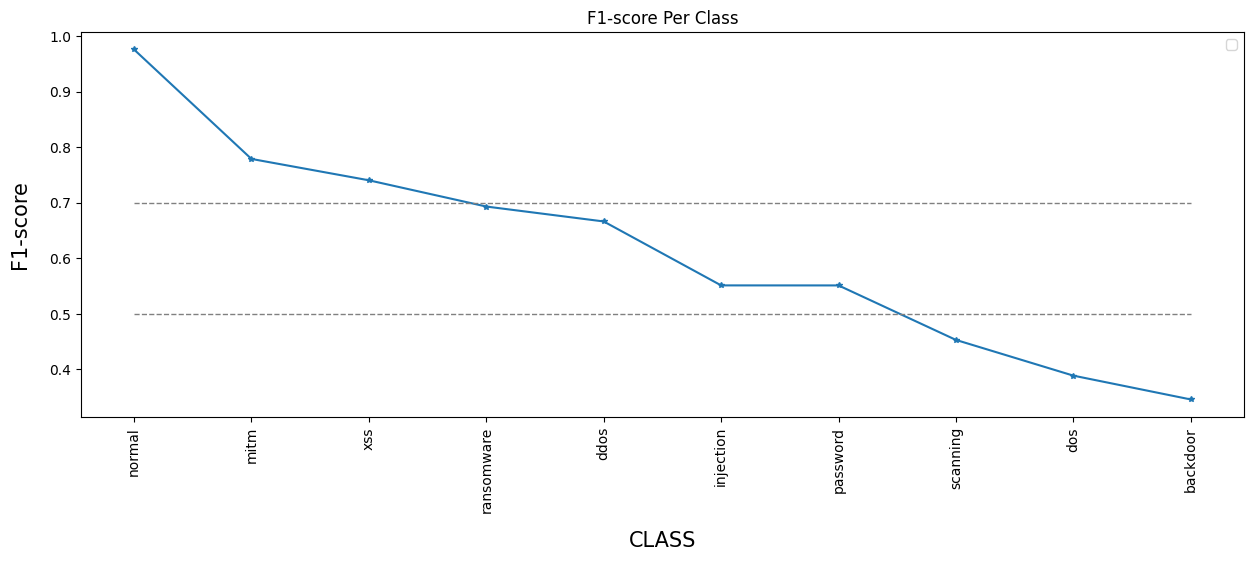

In [66]:
##### TEST
plot_line([score_per_class_df['class'].to_list()], [score_per_class_df['f1_score'].to_list()], [], 'CLASS', 'F1-score', 'F1-score Per Class')

## (2) PCFI
### Obtaining per-class feature importance

In [67]:
rf_opt = RandomForestClassifier(max_depth = depth, n_estimators = n_tree, random_state=42, bootstrap=False,n_jobs=10)
rf_opt.fit(X_train[feats], y_train, sample_weight=weight_of_samples)

RandomForestClassifier(bootstrap=False, max_depth=18, n_estimators=9, n_jobs=10,
                       random_state=42)

In [68]:
### Matrix containing feature importances per feature-class pair
imp_mat = calcImportanceMatrix(rf_opt)

In [69]:
#### GET ordered classes and GET their features and feature importances in that order
imp_mat_ordered = []
score_per_class_df['f1_score'] = score_per_class_df['f1_score']*100
classes_ordered_main_model = score_per_class_df['class'].to_list()
class_scores_ordered = score_per_class_df['f1_score'].to_list()

for cl in classes_ordered_main_model:
    ind_of_class = classes.index(cl)
    imp_mat_ordered.append(imp_mat[ind_of_class])
    
## 2 classes which are not in TEST SET
# classes_ordered_main_model.append('IPhone')
# class_scores_ordered.append(0)
# imp_mat_ordered.append(imp_mat[classes.index('IPhone')])
# classes_ordered_main_model.append('Blipcare Blood Pressure meter')
# class_scores_ordered.append(1)
# imp_mat_ordered.append(imp_mat[classes.index('Blipcare Blood Pressure meter')])

In [70]:
len(classes_ordered_main_model)

10

In [71]:
feature_names = feats

## (3) Outlier Detection

## Generate the data and detect outliers
#### With Plots

In [72]:
def take_derivative(class_name, data_dict, threshold):

    imp_list = data_dict[class_name]
    # print(imp_list)
    # Example CDF data
    x = np.arange(len(imp_list))
    y = imp_list

    # print(len(x))
    # print(len(y))

    # Compute the derivative
    dy_dx = np.gradient(y, x)
    print(dy_dx)
    selected_point_index = len(imp_list)-1
    selected_point = dy_dx[selected_point_index]
    for p_dvt in dy_dx:
        if p_dvt < threshold:
            if np.where(dy_dx == p_dvt)[0] < selected_point_index:
                selected_point_index = np.where(dy_dx == p_dvt)[0]
                selected_point = dy_dx[selected_point_index]
    print(selected_point, selected_point_index)
    #
    # Plot the CDF and its derivative
    plt.figure()
    
    plt.scatter(selected_point_index, imp_list[selected_point_index[0] ], color='red', s=45)
    plt.scatter(selected_point_index, dy_dx[selected_point_index[0] ], color='red', s=45)
    plt.plot(x, y, label='Cumulative Importance')
    plt.plot(x, dy_dx, label='Derivative of Cumulative Importance: ' + str(class_name))
    plt.xlabel('Classes')
    plt.ylabel('Importance')
    plt.legend()
    plt.grid(True)
    plt.show()

In [73]:
max_exponent = 709
x_scores = []
y_importances = []
c_name = []
f_name = []
exp_values = []
normal_importances = []
for c in range(0, len(classes_ordered_main_model)):
    sum_exp_values = 0
    exp_values_per_class = []
    for f in range(0, len(feature_names)):
        c_name.append(classes_ordered_main_model[c])
        f_name.append(feature_names[f])
        x_scores.append(class_scores_ordered[c]/100)
        normal_importances.append(np.array(imp_mat_ordered)[c,f])
        try:
            if(np.array(imp_mat_ordered)[c,f] == 0):
                ### If the values is too big for math.exp
                y_importances.append(max_exponent)
                # print('first set')
            else:
                y_importances.append((1/(np.array(imp_mat_ordered)[c,f]*100)))
            exp_values.append(math.exp(y_importances[-1]))
        except:
            ### If the y_importance values is too big for math.exp
            y_importances[-1] = max_exponent
            exp_values.append(math.exp(y_importances[-1]))
            
# density_df = pd.DataFrame({'c_name': c_name, 'f_name': f_name, 'x_scores': x_scores, 'y_importances': y_importances, 'exp_values': exp_values, 'normalized_exp': normalized_exp_values,  'density': density})
# density_df = pd.DataFrame({'c_name': c_name, 'f_name': f_name, 'x_scores': x_scores, 'normal_importances': normal_importances, 'y_importances': y_importances, 'exp_values': exp_values, 'log10_based_exp': log10_based,'normalized_exp': normalized_exp_values, 'sum_of_importances_log10':sum_of_importances_log10, 'inverse_exp': inverse_exp})
density_df = pd.DataFrame({'c_name': c_name, 'f_name': f_name, 'x_scores': x_scores, 'normal_importances': normal_importances, 'y_importances': y_importances, 'exp_values': exp_values})


density_df['FINAL'] = density_df['exp_values']/(density_df['normal_importances'])
density_df['normal_importances_100'] = density_df['normal_importances']*100
density_df['Feature'] = density_df['f_name'].replace(feature_names, range(len(feature_names)))
        

In [74]:
density_df

,c_name,f_name,x_scores,normal_importances,y_importances,exp_values,FINAL,normal_importances_100,Feature
0,normal,dstport,0.975697,0.081332,0.122954,1.130832e+00,1.390398e+01,8.133155,0
1,normal,ip.len,0.975697,0.113878,0.087813,1.091784e+00,9.587270e+00,11.387849,1
2,normal,Max Packet Length,0.975697,0.042639,0.234525,1.264308e+00,2.965120e+01,4.263936,2
3,normal,ip.ttl,0.975697,0.400924,0.024942,1.025256e+00,2.557235e+00,40.092362,3
4,normal,Packet Length Total,0.975697,0.030633,0.326445,1.386033e+00,4.524641e+01,3.063299,4
...,...,...,...,...,...,...,...,...,...
205,backdoor,FIN Flag Count,0.345552,0.005383,1.857791,6.409561e+00,1.190762e+03,0.538274,16
206,backdoor,tcp.flags.ack,0.345552,0.002626,3.808720,4.509269e+01,1.717454e+04,0.262555,17
207,backdoor,tcp.flags.rst,0.345552,0.000008,709.000000,8.218407e+307,inf,0.000807,18
208,backdoor,ECE Flag Count,0.345552,0.009505,1.052032,2.863464e+00,3.012457e+02,0.950541,19


In [75]:
###### Get the results from other big model of least successful classes ######
# density_df = density_df[['c_name', 'f_name', 'x_scores', 'normal_importances']]
# L_classes = ['MacBook', 'HP Printer', 'PIX-STAR Photo-frame', 'Android Phone', 'TP-Link Smart plug', 'TP-Link Day Night Cloud camera',\
#         'Dropcam', 'Blipcare Blood Pressure meter', 'IPhone']

# L_density_df = pd.read_csv('/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/cluster_model_analysis_results/Proportional_fairness/density_df_big_model_exlClasses.csv')
# L_density_df = L_density_df[['c_name', 'x_scores', 'f_name', 'normal_importances']]
# #
# density_df = density_df[~density_df['c_name'].isin(L_classes)]
# #
# density_df = pd.concat((density_df, L_density_df))

In [76]:
prop_increase_dict = {}
cum_increase_dict = {}

In [77]:
### RELATIVE rate of change
def flag_outliers(df, col_name='normal_importances', th=0.5):
    df = df.assign(outlier=True)
    df = df.reset_index()
    df['ccum_sum'] = np.cumsum(np.clip(df[col_name].to_numpy(),0.01,1)[::-1])[::-1]
    cutoff = []
    last_y = df.loc[1]['ccum_sum']
    # print(df['c_name'].unique()[0])
    # print('last_y', last_y)
    last_decrease = df.loc[0]['ccum_sum']-df.loc[1]['ccum_sum']
    # print('last decrease', last_decrease)
    decreases = [last_decrease]
    rel_decrease = [1]
    for index,row in df[2:].iterrows():
        curr_decrease = last_y - row['ccum_sum']
        # print('curr_decrease', curr_decrease)
        decreases.append(curr_decrease)
        rel_improvement =  last_decrease / curr_decrease
        rel_decrease.append(rel_improvement)
        if rel_improvement < th:
            cutoff.append(index)
        last_y = row['ccum_sum']
        last_decrease = curr_decrease
    # # PLOT
    # f, ax1 = plt.subplots()
    # ax1.plot(decreases, color='C0', label='decreases')
    # ax2 = ax1.twinx()
    # ax2.plot(rel_decrease, color='C1', label='rel_decreases')
    # ax1.set_title(df['c_name'].unique()[0])
    # plt.legend()
    # plt.show()
    if not cutoff:
        cutoff.append(index)
    # print(f'found cutoff: {cutoff[0]}!')
    df['outlier'].iloc[[i for i in range(cutoff[0])]]=False
#     raise Exception
    return df.set_index('index', drop=True)

In [78]:
### RELATIVE rate of change
def flag_outliers_with_cost(df, n_of_features, col_name='normal_importances', th=0.5):
    df = df.assign(outlier=True)
    df = df.reset_index()
    # df['ccum_sum'] = np.cumsum(np.clip(df[col_name].to_numpy(),0.01,1)[::-1])[::-1]
    df['ccum_sum'] = np.cumsum(np.clip(df[col_name].to_numpy(),0.01,1))
    cutoff = []
    last_y = df.loc[1]['ccum_sum']
    # print(df)
    # print(df['c_name'].unique()[0])
    cost_values = [i/n_of_features for i in range(1, (n_of_features+1))]
    total_gain_list = []
    ##
    for index,row in df.iterrows():
        ##
        # print('Feature NO: ', index, 'Total COST: ', cost_values[index], 'Total GAIN: ', row['ccum_sum'], 'DIFF: ', row['ccum_sum'] - cost_values[index])
        # print('Feature NO: ', count_feat, 'UI    :', math.log(row['ccum_sum']) - math.log(count_feat/(15)))
        ##
        total_gain =  row['ccum_sum'] - cost_values[index]
        total_gain_list.append(total_gain)
        ##
    ##
    # if not cutoff_cost:
    #     cutoff_cost.append(index)
    # print(f'found cutoff COST: {cutoff_cost[0]}!')
    ##
    total_gain_list = np.array(total_gain_list)
    index_cost = np.argmax(total_gain_list)
    
    # f, ax1 = plt.subplots()
    # ax1.plot(total_gain_list, color='C0', label='Total gain')
    # # ax2 = ax1.twinx()
    # # ax2.plot(rel_decrease, color='C1', label='rel_decreases')
    # ax1.set_title(df['c_name'].unique()[0])
    # plt.legend()
    # plt.show()
    
    df['outlier'].iloc[[i for i in range(index_cost+1)]]=False
    # print('Number of features to use: ', index_cost)
    # df['outlier'].iloc[[i for i in range(cutoff[0])]]=False
#     raise Exception
    return df.set_index('index', drop=True)

In [79]:
def flag_inliers(df, threshold=0.05):
    inliers=[]
    df = df.reset_index()
    last_increase = 0
    c_name = df['c_name'].unique()[0]
    prop_increase_dict[c_name] = []
    cum_increase_dict[c_name] = []
    cum_score = 0
    for index,row in df.iterrows():
        if index == 0:
            inliers.append(index)
            last_increase = row['normal_importances']
            cum_score = last_increase
            cum_increase_dict[c_name].append(cum_score)
        else:
            # if (row['normal_importances']/last_increase)<0.6:
            #     break
            # else:
            prop_increase_dict[c_name].append(row['normal_importances']/last_increase)
            last_increase = row['normal_importances']
            cum_score = cum_score + last_increase
            cum_increase_dict[c_name].append(cum_score)
            inliers.append(index)
            
    # Compute the derivative
    y = cum_increase_dict[c_name]
    x = np.arange(len(y))
    dy_dx = np.gradient(y, x)
    # print(y)
    # print(dy_dx)
    # print('--')
    selected_point_index = len(y)-1
    for p_dvt in dy_dx:
        if p_dvt < threshold:
            if np.where(dy_dx == p_dvt)[0] < selected_point_index:
                selected_point_index = np.where(dy_dx == p_dvt)[0][0]
    # print(c_name, selected_point, selected_point_index)
    # print(c_name, len(inliers[:selected_point_index + 1]))
    
    df['outlier'].iloc[inliers[:selected_point_index]]=False
    return df.set_index('index', drop=True)

In [80]:
#### CALL flag_outliers per class - RELATIVE RATE of DECREASE
density_df = density_df.assign(outlier=True)
ord_param = 'normal_importances'
density_df = density_df.sort_values(by=ord_param,ascending=False).groupby('c_name', group_keys=False).apply(flag_outliers_with_cost, n_of_features=len(feature_names), col_name=ord_param, th=0.65)
#
density_inliers_df = density_df[density_df['outlier']==False]

In [81]:
len(density_inliers_df)

66

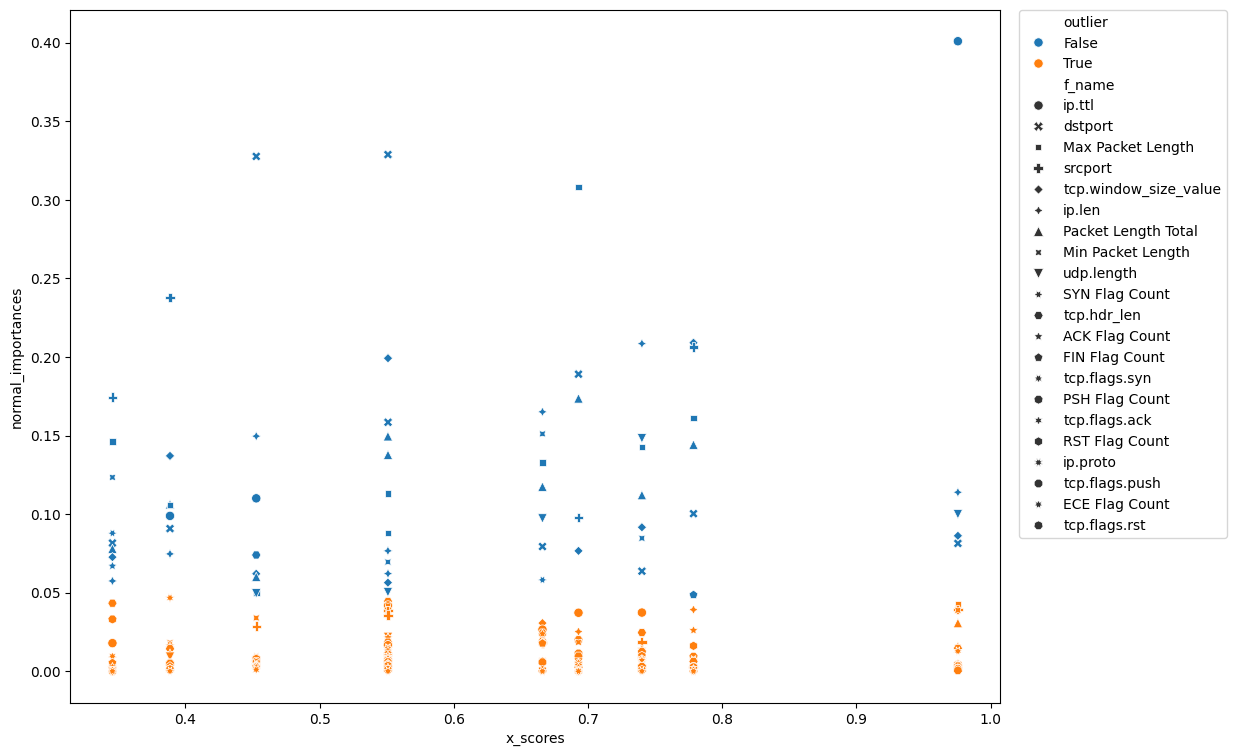

In [82]:
marker_lst = [
    ".", ",", "o", "v", "^", "<", ">", "1", "2", "3", "4", "8", "s", "p", "P", "*", "h", "H", "+", "x", "X",
    "D", "d", "|", "_", 0, 1, 2, 3, 4, 5
]
markers_dict = dict(zip(feature_names,marker_lst))

fig, ax = plt.subplots(figsize=(12,9))
sns.scatterplot(data=density_df, x='x_scores', y='normal_importances', ax=ax, hue='outlier', style="f_name", s=45)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# plt.xlim(0.85, 1)
plt.show()

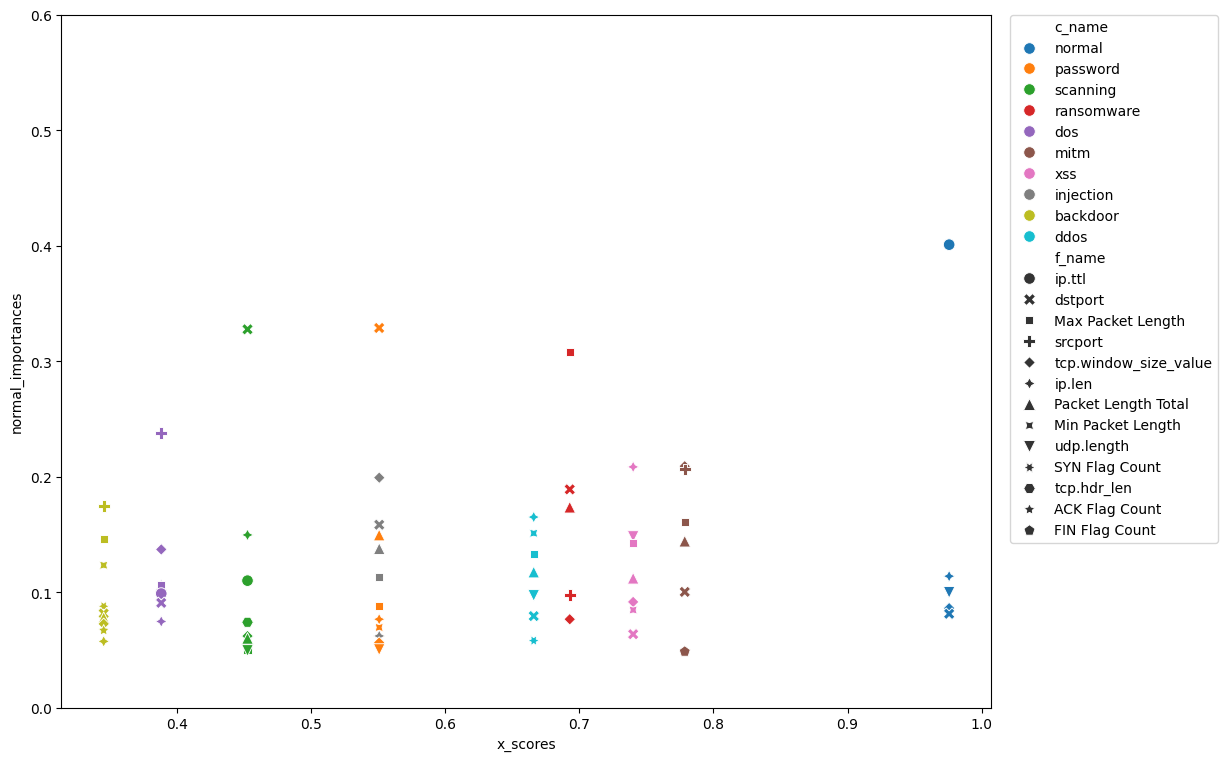

In [83]:
marker_lst = [
    ".", ",", "o", "v", "^", "<", ">", "1", "2", "3", "4", "8", "s", "p", "P", "*", "h", "H", "+", "x", "X",
    "D", "d", "|", "_", 0, 1, 2, 3, 4, 5
]
markers_dict = dict(zip(feature_names,marker_lst))

fig, ax = plt.subplots(figsize=(12,9))
sns.scatterplot(data=density_inliers_df, x='x_scores', y='normal_importances', ax=ax, hue='c_name', style="f_name", s=70)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.ylim(0, 0.6)
plt.show()

## (4) Running Hamming Distance on the data obtained after Outlier Detection

In [84]:
## Generate Binary Array per class for inlier features
def generate_binary_arrays(df, binary_array_dict):
    binary_array = [0]*len(feats_all)
    
    for i in range(0, len(df['outlier'].to_list())):
        if df['outlier'].to_list()[i] == False:
            binary_array[df['f_name_ord'].to_list()[i]] = 1
    
    # binary_array = [int(i == False) for i in df['outlier'].to_list()]
    df['BinaryArray'] = [binary_array]*len(df['outlier'])
    binary_array_dict[df['c_name'].to_list()[0]] = binary_array
    return df

def generate_feature_importance_arrays(df, binary_array_dict):
    binary_array = [0]*len(feats_all)
    
    for i in range(0, len(df['outlier'].to_list())):
        if df['outlier'].to_list()[i] == False:
            binary_array[df['f_name_ord'].to_list()[i]] = df['normal_importances'].to_list()[i]
    
    # binary_array = [int(i == False) for i in df['outlier'].to_list()]
    df['ImportanceArray'] = [binary_array]*len(df['outlier'])
    binary_array_dict[df['c_name'].to_list()[0]] = binary_array
    return df
    
def assign_clusters(df, clustering_result, classes, clustering_method):
    df[clustering_method] = clustering_result[classes.index(df['c_name'].to_list()[0])]
    return df

def weighted_hamming_dist_by_importance_snd(BinaryArray_dict, ImportanceArray_dict, feats):  
    h_distance = []
    classes_for_distance = BinaryArray_dict.keys()
    for c1 in classes_for_distance:
        distance_c1 = []
        for c2 in classes_for_distance:
            distance = 0
            for feat_ind in range(0, len(feats)):
                ### If both classes use or not use the related feature
                if BinaryArray_dict[c1][feat_ind] == BinaryArray_dict[c2][feat_ind]:
                    if BinaryArray_dict[c1][feat_ind] == 1:
                        distance = distance + abs(ImportanceArray_dict[c1][feat_ind] -  ImportanceArray_dict[c2][feat_ind])
                else:
                    # distance = distance + 1
                    if BinaryArray_dict[c1][feat_ind] == 1:
                        distance = distance + ImportanceArray_dict[c1][feat_ind]
                    else:
                        distance = distance + ImportanceArray_dict[c2][feat_ind]        
            distance_c1.append(distance)
        h_distance.append(distance_c1)
    return h_distance

def weighted_hamming_dist_by_importance(BinaryArray_dict, ImportanceArray_dict, feats):  
    h_distance = []
    classes_for_distance = BinaryArray_dict.keys()
    for c1 in classes_for_distance:
        distance_c1 = []
        for c2 in classes_for_distance:
            distance = 0
            for feat_ind in range(0, len(feats)):
                ### If both classes use or not use the related feature
                if BinaryArray_dict[c1][feat_ind] == BinaryArray_dict[c2][feat_ind]:
                    if BinaryArray_dict[c1][feat_ind] == 1:
                        distance = distance + abs(ImportanceArray_dict[c1][feat_ind] -  ImportanceArray_dict[c2][feat_ind])
                else:
                    distance = distance + 1
            distance_c1.append(distance)
        h_distance.append(distance_c1)
    return h_distance

def weighted_hamming_dist_by_score(distance_matrix, classes_ordered, df):
    weighted_distance_matrix = distance_matrix.copy()
    ## get the classes in order
    classes_ordered = df.drop_duplicates(['c_name']).sort_values(by='x_scores', ascending=False)['c_name'].to_list()
    scores_ordered = df.drop_duplicates(['c_name']).sort_values(by='x_scores', ascending=False)['x_scores'].to_list()
    
    for i in range(0, len(weighted_distance_matrix)):
        for j in range(0, len(weighted_distance_matrix)):
            first_c_name = classes_ordered[i]
            second_c_name = classes_ordered[j]
            score_difference = abs(scores_ordered[i] - scores_ordered[j]) 
            # print(first_c_name, second_c_name, score_difference, weighted_distance_matrix[i][j])
            weighted_distance_matrix[i][j] = score_difference*weighted_distance_matrix[i][j]
            # print(weighted_distance_matrix[i][j])
    
    return weighted_distance_matrix

def generate_data_to_cluster(classes_to_cluster, classes_ordered):
    classes_ordered_temp = []
    for i in classes_ordered:
        if i in classes_to_cluster:
            classes_ordered_temp.append(i)
    
    data_to_cluster = density_df[density_df['c_name'].isin(classes_to_cluster)]
    data_to_cluster_inliers_df = density_inliers_df[density_inliers_df['c_name'].isin(classes_to_cluster)]
    
    data_to_cluster = data_to_cluster[data_to_cluster['x_scores'] > 0.1]
    data_to_cluster_inliers_df = data_to_cluster_inliers_df[data_to_cluster_inliers_df['x_scores'] > 0.1]
    
    return classes_ordered_temp, data_to_cluster, data_to_cluster_inliers_df

def get_statistics_of_clustering(classes_to_cluster, score_per_class_df, clustering_result):
    ### To get statistics ###
    classes = classes_to_cluster
    score_per_class_df = score_per_class_df[score_per_class_df['class'].isin(classes_to_cluster)]
    all_classes_in_cluster_order = []
    score_per_class_df['Cluster_F1_Score'] = -1 
    score_per_class_df['Cluster'] = list(clustering_result) + [-1]*(len(classes)- len(clustering_result))
    #
    x = score_per_class_df.groupby(by='Cluster')['class'].apply(list).to_dict()
    ## Get the classes in the order of clusters
    for cl in x.values():
        all_classes_in_cluster_order.extend(cl)
    ##
    cluster_info = pd.DataFrame()
    cluster_info['Cluster'] = x.keys()
    cluster_info['Class List'] = x.values()
    cluster_info['Feature List'] = [-1]*len(cluster_info)
    cluster_info['Depth'] =  -1 
    cluster_info['Tree'] =  -1 
    cluster_info['Feats'] =  -1 
    #
    pd.set_option('max_colwidth', None)
    return cluster_info

#### If you want to run clustering algorithm for specific number of clusters:

In [37]:
classes_analy = []
classes_analy_df = pd.DataFrame(classes_analy,  columns=['class'])

In [38]:
classes_ordered, data_to_cluster, data_to_cluster_inliers_df = generate_data_to_cluster(classes_analy, classes_ordered_main_model)

#### Otherwise:

In [85]:
classes_ordered, data_to_cluster, data_to_cluster_inliers_df = generate_data_to_cluster(classes, classes_ordered_main_model)

#### ---

In [86]:
#### CALL generate_binary_arrays to GENERATE BINARY ARRAY STRINGS to check if the feature is inlier or outlier
data_to_cluster['f_name_ord'] = data_to_cluster['f_name'].replace(feats_all, range(len(feats_all)))
#
BinaryArray_dict = dict.fromkeys(data_to_cluster.sort_values(by='x_scores', ascending=False)['c_name'], None)
data_to_cluster['f_name_ord'] = data_to_cluster['f_name'].replace(feats_all, range(len(feats_all)))
#
# Generate Binary Array
ord_param = 'f_name_ord'
data_to_cluster = data_to_cluster.sort_values(by=ord_param,ascending=True).groupby('c_name', group_keys=False).apply(generate_binary_arrays, binary_array_dict=BinaryArray_dict)
# 
## Generate Feature Importance Array
ImportanceArray_dict = dict.fromkeys(data_to_cluster.sort_values(by='x_scores', ascending=False)['c_name'], None)
data_to_cluster = data_to_cluster.sort_values(by=ord_param,ascending=True).groupby('c_name', group_keys=False).apply(generate_feature_importance_arrays, binary_array_dict=ImportanceArray_dict)

In [87]:
#### Calculate Hamming Distance weighted with feature importance differences
weighted_hamming_distance = weighted_hamming_dist_by_importance(BinaryArray_dict, ImportanceArray_dict, feats_all)
#### Weighted Hamming Distance multiplied by F1 Score difference
weighted_hamming_distance = weighted_hamming_dist_by_score(weighted_hamming_distance, classes_ordered, data_to_cluster_inliers_df)

In [88]:
weighted_hamming_distance_df = pd.DataFrame(weighted_hamming_distance, columns=classes_ordered)
weighted_hamming_distance_df['Label'] = classes_ordered

## (5) Decide the number of clusters used as a parameter in Agglomerative Clustering

#### Silhouette Score

2 0.5342720176937797 0.034272017693779744
3 0.5343785350331547 0.20104520169982137
4 0.5668611091297938 0.3168611091297938
5 0.4513646648049253 0.2513646648049253
6 0.4806533149097594 0.31398664824309275
7 0.3837971331429894 0.24093999028584656
8 0.25949468526459013 0.13449468526459013
9 0.19984459392346204 0.08873348281235094


Text(0, 0.5, 'Silhouette score')

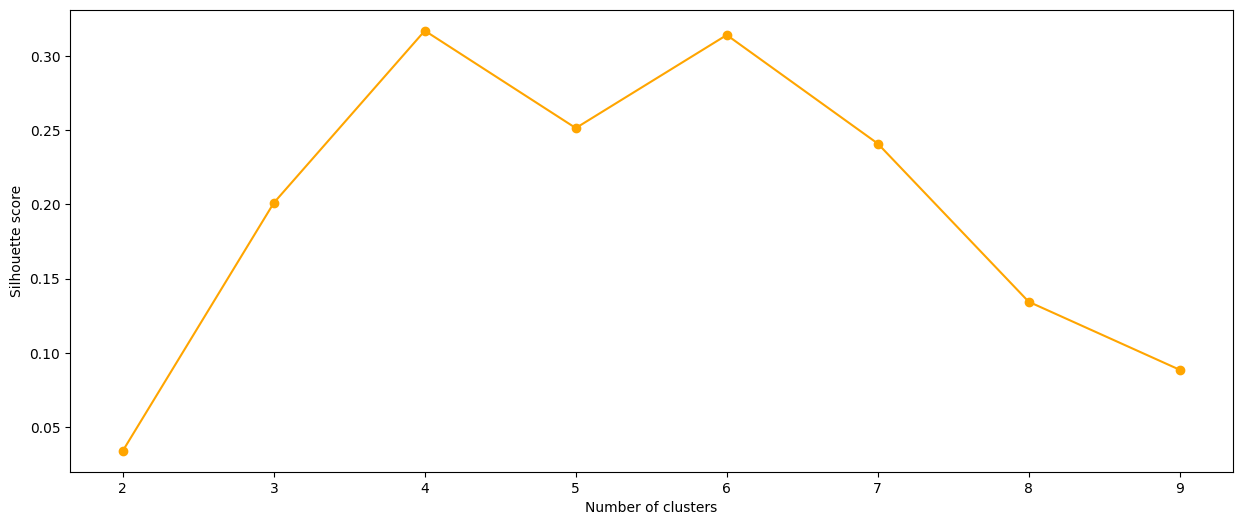

In [38]:
##### Silhouette score #####
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score

def calculate_silhoutte_score(data, n_of_cluster):
    
    model_average = AgglomerativeClustering(n_clusters=n_of_cluster, linkage='complete', affinity='precomputed')
    clustering_results = model_average.fit_predict(data)
    silhouette_score_val = silhouette_score(data, clustering_results, metric='precomputed')
    return silhouette_score_val, clustering_results

n_of_clusters = list(range(2, 10)) #------Number of Clusters in the data
avg_scores = []
for n_of_cluster in n_of_clusters: 
    score, clustering_results = calculate_silhoutte_score(weighted_hamming_distance, n_of_cluster)
    # modified_score_penalty = score - ((len(weighted_hamming_distance)/n_of_cluster)/10)
    count_n_of_cluster = [0 for i in range(0, n_of_cluster)]
    for c_result in clustering_results:
        count_n_of_cluster[c_result] = count_n_of_cluster[c_result] + 1
    max_class_in_cluster = max(count_n_of_cluster)   
    modified_score_penalty = score - (1/n_of_cluster)
    # modified_score_penalty = score - (max_class_in_cluster/len(weighted_hamming_distance))
    print(n_of_cluster, score, modified_score_penalty)
    avg_scores.append(modified_score_penalty)

plt.figure(figsize=(15,6))
 
plt.plot(n_of_clusters, avg_scores, marker="o", color="orange")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")

## (6) Run clustering algorithms and obtained the cluster&features per cluster

In [89]:
# Initialize the Agglomerative clustering model
model_average = AgglomerativeClustering(n_clusters=6, linkage='complete', affinity='precomputed')
#
clusters_average = model_average.fit_predict(weighted_hamming_distance)
#
# toy_data_df['AGGLOMERATIVE'] = clusters_average
weighted_hamming_distance_df['Cluster'] = clusters_average
clusters_average

array([5, 4, 1, 4, 1, 3, 3, 2, 0, 0])

In [90]:
data_to_cluster = data_to_cluster.groupby('c_name', group_keys=False).apply(assign_clusters, clustering_result=clusters_average, classes=classes_ordered, clustering_method='Agg_Cluster')
#
data_to_cluster_inliers_df = data_to_cluster_inliers_df.groupby('c_name', group_keys=False).apply(assign_clusters, clustering_result=clusters_average, classes=classes_ordered, clustering_method='Agg_Cluster')

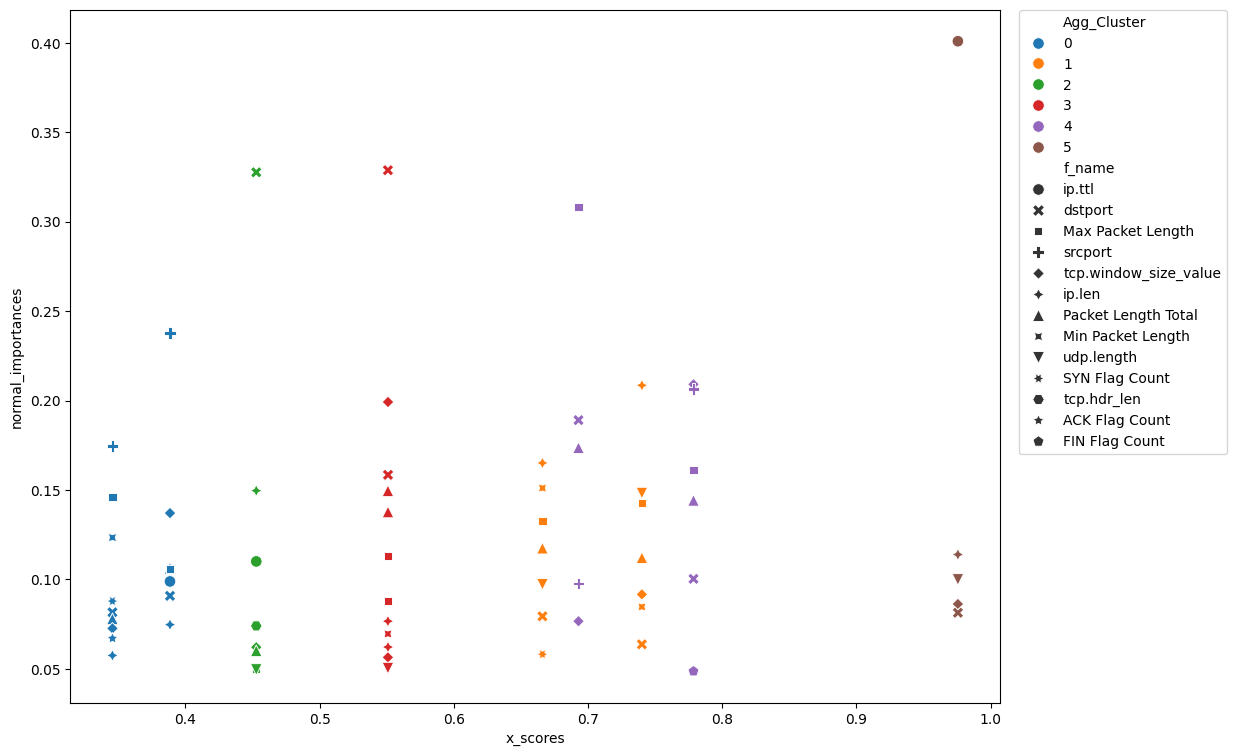

In [91]:
marker_lst = [
    ".", ",", "o", "v", "^", "<", ">", "1", "2", "3", "4", "8", "s", "p", "P", "*", "h", "H", "+", "x", "X",
    "D", "d", "|", "_", 0, 1, 2, 3, 4, 5
]
markers_dict = dict(zip(feature_names,marker_lst))

fig, ax = plt.subplots(figsize=(12,9))
sns.scatterplot(data=data_to_cluster_inliers_df, x='x_scores', y='normal_importances', ax=ax, hue='Agg_Cluster', style="f_name", s=70, palette="tab10")
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# plt.xlim(0.7, 1)
plt.show()

In [92]:
cluster_info = get_statistics_of_clustering(classes, score_per_class_df, clusters_average)
cluster_info

,Cluster,Class List,Feature List,Depth,Tree,Feats
0,0,"[dos, backdoor]",-1,-1,-1,-1
1,1,"[xss, ddos]",-1,-1,-1,-1
2,2,[scanning],-1,-1,-1,-1
3,3,"[injection, password]",-1,-1,-1,-1
4,4,"[mitm, ransomware]",-1,-1,-1,-1
5,5,[normal],-1,-1,-1,-1


In [93]:
#### To get cluster statistics ####
for cluster in list(set(clusters_average)):
    print('\n CLUSTER: ', cluster)
    cluster_df = data_to_cluster_inliers_df[data_to_cluster_inliers_df['Agg_Cluster'] == cluster]
    feat_importances_dict = cluster_df.groupby('f_name')['normal_importances'].mean().to_dict()
    feat_importance_df = pd.DataFrame()
    feat_importance_df['f_name'] = feat_importances_dict.keys()
    feat_importance_df['f_imp'] = feat_importances_dict.values()
    feat_importance_df = feat_importance_df.sort_values(by='f_imp', ascending=False)
    print('Number of Classes: ', len(cluster_df['c_name'].unique()))
    print('Number of Features: ', len(cluster_df['f_name'].unique()))
    print('------')
    print('Classes: ', cluster_df['c_name'].unique())
    print('Features: ', feat_importance_df['f_name'].to_list())
    print('Class Score: ', cluster_df['x_scores'].unique())
    print('------')
    #
    cluster_info.loc[cluster_info['Cluster'] == cluster, 'Feature List'] = str(feat_importance_df['f_name'].to_list())


 CLUSTER:  0
Number of Classes:  2
Number of Features:  10
------
Classes:  ['dos' 'backdoor']
Features:  ['srcport', 'Max Packet Length', 'Min Packet Length', 'tcp.window_size_value', 'ip.ttl', 'Packet Length Total', 'SYN Flag Count', 'dstport', 'ACK Flag Count', 'ip.len']
Class Score:  [0.38844885 0.34555176]
------

 CLUSTER:  1
Number of Classes:  2
Number of Features:  8
------
Classes:  ['xss' 'ddos']
Features:  ['ip.len', 'Max Packet Length', 'udp.length', 'Min Packet Length', 'Packet Length Total', 'tcp.window_size_value', 'dstport', 'SYN Flag Count']
Class Score:  [0.74017805 0.66605869]
------

 CLUSTER:  2
Number of Classes:  1
Number of Features:  8
------
Classes:  ['scanning']
Features:  ['dstport', 'ip.len', 'ip.ttl', 'tcp.hdr_len', 'tcp.window_size_value', 'Packet Length Total', 'Max Packet Length', 'udp.length']
Class Score:  [0.45273836]
------

 CLUSTER:  3
Number of Classes:  2
Number of Features:  7
------
Classes:  ['password' 'injection']
Features:  ['dstport', 

In [94]:
type(cluster_info.style.set_properties(**{'text-align': 'left'}))
cluster_info

,Cluster,Class List,Feature List,Depth,Tree,Feats
0,0,"[dos, backdoor]","['srcport', 'Max Packet Length', 'Min Packet Length', 'tcp.window_size_value', 'ip.ttl', 'Packet Length Total', 'SYN Flag Count', 'dstport', 'ACK Flag Count', 'ip.len']",-1,-1,-1
1,1,"[xss, ddos]","['ip.len', 'Max Packet Length', 'udp.length', 'Min Packet Length', 'Packet Length Total', 'tcp.window_size_value', 'dstport', 'SYN Flag Count']",-1,-1,-1
2,2,[scanning],"['dstport', 'ip.len', 'ip.ttl', 'tcp.hdr_len', 'tcp.window_size_value', 'Packet Length Total', 'Max Packet Length', 'udp.length']",-1,-1,-1
3,3,"[injection, password]","['dstport', 'Packet Length Total', 'tcp.window_size_value', 'Max Packet Length', 'Min Packet Length', 'ip.len', 'udp.length']",-1,-1,-1
4,4,"[mitm, ransomware]","['Max Packet Length', 'Packet Length Total', 'srcport', 'dstport', 'tcp.window_size_value', 'FIN Flag Count']",-1,-1,-1
5,5,[normal],"['ip.ttl', 'ip.len', 'udp.length', 'tcp.window_size_value', 'dstport']",-1,-1,-1


In [95]:
### Store the clustering results - Clusters + Features
# cluster_info.to_csv('cluster_info_ToNIoT_10CL_6cluster.csv')

#### In this step, run the model analysis per cluster by using provided scripts run_experiments.sh

## (7) Model analysis results evaluation - per cluster

In [96]:
# list of all extracted features
feats_all = ["ip.len",'ip.hdr_len',"ip.ttl","tcp.flags.syn","tcp.flags.ack","tcp.flags.push","tcp.flags.fin","tcp.flags.rst", "tcp.flags.reset",\
            "tcp.flags.ece","ip.proto","srcport","dstport","tcp.window_size_value","tcp.hdr_len","udp.length", 'UDP Len Min', 'UDP Len Max', 'UDP Len Total',\
            "Min Packet Length","Max Packet Length","Packet Length Mean","Packet Length Total",\
                "Flow IAT Min","Flow IAT Max","Flow IAT Mean","Flow Duration",\
                    "SYN Flag Count","ACK Flag Count","PSH Flag Count","FIN Flag Count","RST Flag Count","ECE Flag Count", "Packet Count"]

feats_sizes = [16, 16, 8, 1, 1, 1, 1, 1, 1,
               1, 8, 16, 16, 16, 4, 16, 16, 16, 16,
                16, 16, 16, 16,
                32, 32, 32, 32,
                8, 8, 8, 8, 8, 8, 16]

feats_size_dict = {}
for f_ind in range(0, len(feats_all)):
    feats_size_dict[feats_all[f_ind]] = feats_sizes[f_ind]
    
available_TCAM_table = 24*12

In [97]:
def calculate_score(support_total, mult_score_support, score):
    macro_score = np.mean(np.array(score))
    weighted_score = np.sum(mult_score_support)/support_total
    
    return macro_score, weighted_score

def concat_csvs(path, dir_entries, use_case):
    d_frames = []
    count = 2
    
    for dir_csv in dir_entries:
        f_name = path + dir_csv
        # print(f_name)
        i_df = pd.read_csv(f_name, sep=';')
        # if use_case == 'planter':
        #     i_df['N_Leaves'] = 500
        #     i_df['New_Macro_F1'] = i_df['macro']
        #     i_df['New_Weighted_F1'] = i_df['weighted']
        #     i_df = i_df.loc[~((i_df['tree'] == 5) & (i_df['no_feats']>8))]
        # if use_case == 'flowrest':
        #     i_df['N_Leaves'] = 500
        #     i_df = i_df.loc[~((i_df['tree'] == 5) & (i_df['no_feats']>5))]
        #     i_df = i_df.loc[~((i_df['tree'] == 3) & (i_df['no_feats']>8))]
        #     i_df = i_df[i_df['tree']  != 2]
        #     i_df = i_df[i_df['tree']!= 4]
        if use_case == 'jewel':
            i_df = i_df.loc[~((i_df['tree'] == 5) & (i_df['no_feats']>4))]
            i_df = i_df.loc[~((i_df['tree'] == 3) & (i_df['no_feats']>7))]
            i_df = i_df[i_df['tree']  != 2]
            i_df = i_df[i_df['tree']!= 4]

        i_df = i_df[['depth','tree', 'no_feats', 'New_Macro_F1', 'New_Weighted_F1', 'N_Leaves', 'feats']]
        # i_df = i_df[i_df['depth'] > 8]
        i_df = i_df[i_df['tree'] < 6]
        # i_df = i_df[i_df['tree']  != 2]
        # i_df = i_df[i_df['tree']!= 4]
        i_df = i_df[i_df['no_feats'] < 11]
        i_df = i_df[i_df['N_Leaves'] > 120]
        i_df['N'] = count
        i_df['F1_score'] = i_df.apply(lambda x: 0.5*(x['New_Macro_F1'] + x['New_Weighted_F1']), axis=1)
        # i_df['F1_score'] = i_df['New_Macro_F1']
        d_frames.append(i_df)
        # print(len(i_df))
        count = count + 1
        
    # print(d_frames)
    return pd.concat(d_frames)

def calculate_tcam_for_codetables(models_df):
    
    models_df['tcam_codetable'] = models_df.apply(lambda x: (int(x['N_Leaves']/44) + 1)*x['tree'], axis=1)

    return models_df

def calculate_tcam_for_featable(models_df):
    feats_for_all_models = list(models_df['feats'])
    tcam_usage_per_model = []
    for feats_in_models in feats_for_all_models:
        feats_in_models_list = feats_in_models[2:][:-2].split('\', \'')
        tcam_usage = 0
        # print(feats_in_models_list)
        for feat in feats_in_models_list:
            # print(feat)
            bit_length = feats_size_dict[feat]
            tcam_usage = tcam_usage + int((2*bit_length)/44) +1
            # print(bit_length, tcam_usage)
        
        tcam_usage_per_model.append(tcam_usage) 
    models_df['tcam_feature_table'] = tcam_usage_per_model
    return models_df

def total_tcam_usage(models_df):
    models_df['total_tcam_tbl_usage'] = models_df.apply(lambda x: x['tcam_feature_table'] + x['tcam_codetable'], axis=1)
    models_df['total_tcam_usage'] = models_df.apply(lambda x: x['total_tcam_tbl_usage']/available_TCAM_table, axis=1)
    # models_df['success_score'] = models_df.apply(lambda x: 0.5*(x['F1_score'] + (1-x['total_tcam_usage']) ), axis=1)
    # models_df['penalty'] = np.where(models_df['tree'] == 5, 1, 0)
    models_df['success_score'] = models_df.apply(lambda x: (0.5*x['Avg_F1_score'] + 0.5*(1-x['total_tcam_usage'])), axis=1)
    return models_df

def plot_scatter(x, y, x1, y1, xlabel, ylabel, name, outfile):

    font = {'family': 'sans-serif',
            'weight': 'normal',
            'size': 19}
    plt.rc('font', **font)

    plt.figure(figsize=(5, 4))
    
    if name == 'jewel':
        plt.scatter(x, y, c='#6E7E99', alpha=0.28, edgecolors='none')
    else:
        plt.scatter(x, y, c='#6E7E99', alpha=0.5, edgecolors='none')
    # plt.scatter(x1, y1, c='#E06B5A', alpha=1, edgecolors='none')
    plt.scatter(x1, y1, c='#EE4B2B', alpha=1, edgecolors='none', s=200)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(0,25)
    plt.ylim(0,105)
    plt.xticks([0, 5, 10, 15, 20, 25])
    
    # plt.savefig(outfile, dpi=200, bbox_inches='tight', pad_inches=0.1)
    
    plt.show()

In [98]:
def select_best_models_per_cluster(n_values, n_of_clusters, total_n_classes, cluster_info, score_per_class_df, type_of_run, folder_name, use_case):
    
    ### For each cluster 
    for cl in range(0, n_of_clusters):
        d_frames = []
        ### For each value of N
        for nd in n_values:
            #### Get the related model analysis file and concat with the nd value
            if type_of_run=="Limited":
                f_name = folder_name + "/" + use_case + "_Limited_"+str(nd)+"pkts_noTime.csv"
            elif type_of_run=="With_Others":
                # f_name = folder_name + "/" + use_case + "_models_"+str(nd)+"pkts_PF_WB_" + str(n_of_clusters) + "CL_noTime_Cluster" + str(cl) + "_WithOther.csv"
                f_name = folder_name + "/" + use_case + "_models_"+str(nd)+"pkts_PF_WB_" + str(n_of_clusters) + "CL_noTime_Cluster" + str(cl) + "_6Cluster.csv"
            elif type_of_run=="Ordered":
                f_name = folder_name + "/" + use_case + "_models_"+str(nd)+"pkts_" + str(total_n_classes) + "CL_Cluster" + str(cl) + "_MACRO_Ordered_withOptimizer_NOdelta_051342.csv"
                
            else:
                f_name = folder_name + "/" + use_case + "_models_"+str(nd)+"pkts_PF_WB_" + str(n_of_clusters) + "CL_noTime_Cluster" + str(cl) + "_WithoutOther.csv"
                # f_name = folder_name + "/" + use_case + "_models_"+str(nd)+"pkts_PF_WB_" + str(total_n_classes) + "CL_Cluster" + str(cl) + "_newHamming_WithoutOther.csv"
            try:
                model_analysis_for_nth = pd.read_csv(f_name, sep=';')
            except:
                print(f_name)
                continue
            model_analysis_for_nth['N'] = nd
            #
            model_analysis_for_nth['Avg_F1_score'] = model_analysis_for_nth.apply(lambda x: (1)*(x['Macro_f1_FL']), axis=1) ###?? MICRO ? 
            # model_analysis_for_nth['Avg_F1_score'] = model_analysis_for_nth.apply(lambda x: (0.5)*(x['Macro_f1_FL'] + x['Weighted_f1_FL']), axis=1) ###?? MICRO ? 
            # model_analysis_for_nth['Avg_F1_score'] = model_analysis_for_nth.apply(lambda x: (1/3)*(x['Macro_f1_FL'] + x['Weighted_f1_FL'] + x['Micro_f1_FL']), axis=1) ###?? MICRO ? 
            d_frames.append(model_analysis_for_nth)
        models_for_cluster = pd.concat(d_frames)
        models_for_cluster = models_for_cluster.reset_index()
        
        #### Calculate TOTAL TCAM usage and calculate SUCCESS SCORE
        models_with_tcam_info = calculate_tcam_for_codetables(models_for_cluster)
        models_with_tcam_info = calculate_tcam_for_featable(models_with_tcam_info)
        models_with_tcam_info = total_tcam_usage(models_with_tcam_info)
        ####
        
        #### ORDER in terms of SUCCESS SCORE and choose the BEST
        # print(models_with_tcam_info.sort_values('success_score', ascending=0).head(1))
        chosen_model_tcam_usage = models_with_tcam_info.sort_values('success_score', ascending=0)['total_tcam_usage'].to_list()[0]*100
        chosen_model_avg_f1_score = models_with_tcam_info.sort_values('success_score', ascending=0)['Avg_F1_score'].to_list()[0]*100
        chosen_model_index = models_with_tcam_info.sort_values('success_score', ascending=0).head(1).index.to_list()[0]
        # print(chosen_model_index, chosen_model_tcam_usage, chosen_model_avg_f1_score)
        ####
        
        chosen_model = models_with_tcam_info.loc[chosen_model_index]
        
        #### Store the information of chosen model
        
        cl_report = convert_str_to_dict(chosen_model['cl_report_FL'])
        # if type_of_run=="Ordered":
        cluster_info.loc[cluster_info['Cluster'] == cl, 'Depth_' + type_of_run] = chosen_model['depth']
        # else:
        #     cluster_info.loc[cluster_info['Cluster'] == cl, 'Depth_' + type_of_run] = int(chosen_model['depth'])
        cluster_info.loc[cluster_info['Cluster'] == cl, 'Tree_' + type_of_run] = int(chosen_model['tree'])
        cluster_info.loc[cluster_info['Cluster'] == cl, 'Feats_' + type_of_run] = int(chosen_model['no_feats'])
        cluster_info.loc[cluster_info['Cluster'] == cl, 'Feats_Names_' + type_of_run] = chosen_model['feats']
        cluster_info.loc[cluster_info['Cluster'] == cl, 'N_Leaves_' + type_of_run] = int(chosen_model['N_Leaves'])
        cluster_info.loc[cluster_info['Cluster'] == cl, 'N_' + type_of_run] = int(chosen_model['N'])
        cluster_info.loc[cluster_info['Cluster'] == cl, 'Macro_f1_FL_' + type_of_run] = chosen_model['Macro_f1_FL']*100
        cluster_info.loc[cluster_info['Cluster'] == cl, 'Weighted_f1_FL_' + type_of_run] = chosen_model['Weighted_f1_FL']*100
        cluster_info.loc[cluster_info['Cluster'] == cl, 'Micro_f1_FL_' + type_of_run] = chosen_model['Micro_f1_FL']*100
        cluster_info.loc[cluster_info['Cluster'] == cl, 'Total_TCAM_Usage_' + type_of_run] = chosen_model['total_tcam_usage']*100
        #
        result_dict = {}
        for d_keys in cl_report.keys():
            if (d_keys != 'accuracy') and (d_keys != 'micro avg'):
                result_dict[d_keys] = cl_report[d_keys]['f1-score']
                if d_keys in classes:
                    df_col = 'Cluster_F1_Score_' + type_of_run
                    score_per_class_df.loc[score_per_class_df['class'] == d_keys, df_col] = cl_report[d_keys]['f1-score']*100
                    score_per_class_df.loc[score_per_class_df['class'] == d_keys, 'Cluster'] = cl
        ####
        
        #### PLOT the chosen model (SCATTER) ####
        # tcam_usage = list(models_with_tcam_info['total_tcam_usage'])
        # weighted_scores = list(models_with_tcam_info['Avg_F1_score'])
        
        # x = [i * 100 for i in tcam_usage]
        # y = [i * 100 for i in weighted_scores]

        # plot_scatter(x, y, chosen_model_tcam_usage, chosen_model_avg_f1_score, "Usage of TCAM Resources [%]", "", 'jewel', 'model_analysis_results/unibs_jewel_Success.pdf')
        ####

    return cluster_info, score_per_class_df

In [99]:
### Initialize dataframes to use for statistics
total_n_classes = 10
n_of_clusters = 6
cluster_info = pd.read_csv('/home/nds-admin/distributed_in_band/ToN-IoT/cluster_info/cluster_info_ToN-IoT_'+str(total_n_classes)+'CL_'+str(n_of_clusters)+'cluster.csv', sep=',')
# print(cluster_info)
cluster_info = cluster_info[['Cluster', 'Class List', 'Feature List']]
# cluster_info['N'] = [-1]*len(cluster_info)
score_per_class_df['Cluster'] = [-1]*len(score_per_class_df)
score_per_class_df['Cluster_F1_Score_With_Others'] = [-1]*len(score_per_class_df)
score_per_class_df['Cluster_F1_Score_Without_Others'] = [-1]*len(score_per_class_df)

In [100]:
cluster_info, scores_df = select_best_models_per_cluster([2,3,4,5], n_of_clusters, total_n_classes, cluster_info, score_per_class_df, "Limited", '/home/nds-admin/distributed_in_band/ToN-IoT/model_analysis_results/limited_models', 'ToN-IoT')
cluster_info, scores_df = select_best_models_per_cluster([2,3,4], n_of_clusters, total_n_classes, cluster_info, score_per_class_df, "With_Others", '/home/nds-admin/distributed_in_band/ToN-IoT/model_analysis_results/clustering_results', 'ton')
cluster_info, scores_df = select_best_models_per_cluster([2,3,4], n_of_clusters, total_n_classes, cluster_info, score_per_class_df, "Ordered", '/home/nds-admin/distributed_in_band/ToN-IoT/model_analysis_results/clustering_results/6CLuster_Ordered', 'ToN-IoT')

In [101]:
## total TCAM usage
print(sum(cluster_info['Total_TCAM_Usage_Limited'].to_list())/6)
print(sum(cluster_info['Total_TCAM_Usage_Ordered'].to_list()))
print(sum(cluster_info['Total_TCAM_Usage_With_Others'].to_list()))
# print(sum(cluster_info['Total_TCAM_Usage_Without_Others'].to_list()[1:]))

5.208333333333335
14.23611111111111
19.09722222222222


In [102]:
cluster_info_others = cluster_info[['Cluster', 'Class List', 'Feats_Names_With_Others', 'Depth_With_Others', 'Tree_With_Others', 'Feats_With_Others', 'N_Leaves_With_Others', 'N_With_Others', 'Total_TCAM_Usage_With_Others', 'Macro_f1_FL_With_Others', 'Weighted_f1_FL_With_Others', 'Micro_f1_FL_With_Others']]

In [52]:
#### Store the best model info per cluster to use in the optimization problem
# cluster_info_others.to_csv('Best_models_perCluster_with_others_6CL.csv')

## (8) OPTIMIZATION - Order the clusters

In [151]:
clusters_best_model_info = pd.read_csv('/home/nds-admin/distributed_in_band/ToN-IoT/cluster_info/Best_models_perCluster_with_others_6CL.csv')

In [152]:
cluster_list = []
all_classes_in_clusters = []
cluster_info_all_classes = []
cluster_no = 0
for cl in clusters_best_model_info['Class List'].to_list():
    classes_str = cl[2:-2] 
    classes = classes_str.split("', '")
    cluster_list.append(classes)
    all_classes_in_clusters.extend(classes)
    cluster_info_all_classes.extend([cluster_no]*len(classes))
    cluster_no = cluster_no + 1
print(all_classes_in_clusters)
print(cluster_info_all_classes)


['dos', 'backdoor', 'xss', 'ddos', 'scanning', 'injection', 'password', 'mitm', 'ransomware', 'normal']
[0, 0, 1, 1, 2, 3, 3, 4, 4, 5]


#### Run to obtain Confusion Matrix if it is not saved before

In [153]:
cm_matrix = pd.DataFrame()
cm_matrix['Classes'] = [i for i in all_classes_in_clusters]
cm_matrix_cluster = pd.DataFrame()
cm_matrix_cluster['Clusters'] = [i for i in range(0, len(cluster_list))]
##
for i in range(0, len(cluster_list)):
    npkts = int(clusters_best_model_info.loc[i]['N_With_Others'])
    n_tree = int(clusters_best_model_info.loc[i]['Tree_With_Others'])
    # depth = int(clusters_best_model_info.loc[i]['Depth_With_Others'])
    depth=10
    max_n_leaves = int(clusters_best_model_info.loc[i]['N_Leaves_With_Others'])
    #
    feat_names_str = clusters_best_model_info.loc[i]['Feats_Names_With_Others']
    feat_names_str = feat_names_str[2:-2] 
    feat_names = feat_names_str.split("', '")
    print(npkts, n_tree, len(feat_names), max_n_leaves)
    #
    classes = cluster_list[i]
    total_classes = len(classes)
    classes.append('Other')
    classes_df = pd.DataFrame(classes, columns=['class'])
    #
    cluster_perf_dict = {}
    for cl in cm_matrix_cluster['Clusters'].to_list():
        cluster_perf_dict[cl] = 0
    #
    ####
    #
    cl_report, expanded_y_true, expanded_y_pred, expanded_weights, expanded_y_true_all = analyze_model(npkts, depth, n_tree, max_n_leaves, feat_names, classes, classes_df)
    #
    pred_df = pd.DataFrame()
    pred_df['True_Label_Cluster'] = expanded_y_true
    pred_df['Pred_Label_Cluster'] = expanded_y_pred
    pred_df['True_Label_All'] = expanded_y_true_all
    pred_df['Weight_per_packet'] = expanded_weights
    #
    # performance_dict = {}
    for cla_in_clu in classes[:-1]:
        performance_vals = []
        cla_in_clu_ind = classes.index(cla_in_clu)
        for cla in all_classes_in_clusters:
            if cla in classes:
                cla_ind = classes.index(cla)
                metric_val = sum(pred_df[((pred_df['True_Label_Cluster'] == cla_ind) & (pred_df['Pred_Label_Cluster'] == cla_in_clu_ind))]['Weight_per_packet'].to_list())
                performance_vals.append(metric_val)
                #
                cluster_perf_dict[i] = cluster_perf_dict[i] + metric_val
            else:
                cla_ind = all_classes_in_clusters.index(cla)
                cluster_of_cls = cluster_info_all_classes[cla_ind]
                metric_val = sum(pred_df[((pred_df['True_Label_All'] == cla) & (pred_df['Pred_Label_Cluster'] == cla_in_clu_ind))]['Weight_per_packet'].to_list())
                performance_vals.append(metric_val)
                cluster_perf_dict[cluster_of_cls] = cluster_perf_dict[cluster_of_cls] + metric_val
        cm_matrix_cluster[str(i)] = cluster_perf_dict.values()
        cm_matrix[cla_in_clu] = performance_vals


3 5 3 41
Num Labels:  3
RandomForestClassifier(bootstrap=False, max_leaf_nodes=41, n_estimators=5,
                       n_jobs=10, random_state=42)
0.622169604490047 0.9995985852647555 0.9996843853820515
3 2 6 85
Num Labels:  3
RandomForestClassifier(bootstrap=False, max_leaf_nodes=85, n_estimators=2,
                       n_jobs=10, random_state=42)
0.729913969200496 0.7348632470358184 0.741084388884454
2 2 7 129
Num Labels:  2
RandomForestClassifier(bootstrap=False, max_leaf_nodes=129, n_estimators=2,
                       n_jobs=10, random_state=42)
0.7596550333850463 0.9694891606945636 0.9663997532168773
4 2 7 41
Num Labels:  3
RandomForestClassifier(bootstrap=False, max_leaf_nodes=41, n_estimators=2,
                       n_jobs=10, random_state=42)
0.735896940523952 0.8521226650713926 0.8618674046336814
2 1 5 173
Num Labels:  3
RandomForestClassifier(bootstrap=False, max_leaf_nodes=173, n_estimators=1,
                       n_jobs=10, random_state=42)
0.8242578835971855 0.9

In [ ]:
# cm_matrix.to_csv('CM_matrix_all_classes_after_clustering_6CL.csv')
# cm_matrix_cluster.to_csv('CM_matrix_Cluster_after_clustering_6CL.csv')

In [154]:
cm_matrix_cluster

,Clusters,0,1,2,3,4,5
0,0,8.0,0.000000,5.916667,4.211898,4.665321,10.000000
1,1,0.0,21234.231597,1218.957217,1484.588447,1.800000,87.009524
2,2,0.0,187.384921,1171.796703,68.529108,3.000000,19.000000
3,3,0.0,1422.271497,25.747239,9362.753126,0.090909,7.772222
4,4,0.0,0.000000,116.124578,0.000000,236.287686,14.000000
5,5,0.0,179.186312,61.785858,13.003090,1.666667,8305.116474


In [155]:
cm_matrix

,Classes,dos,backdoor,xss,ddos,scanning,injection,password,mitm,ransomware,normal
0,dos,1.0,0.0,0.000000,0.000000,0.000000,2.575535,0.000000,0.000000,0.000000,0.000000
1,backdoor,0.0,7.0,0.000000,0.000000,5.916667,1.636364,0.000000,0.000000,4.665321,10.000000
2,xss,0.0,0.0,10265.860201,231.286168,31.631582,435.164518,16.758333,0.800000,0.000000,23.666667
3,ddos,0.0,0.0,738.822489,9998.262739,1187.325635,911.363436,121.302160,0.000000,1.000000,63.342857
4,scanning,0.0,0.0,172.809524,14.575397,1171.796703,38.017347,30.511761,0.000000,3.000000,19.000000
5,injection,0.0,0.0,949.217765,278.972555,23.747239,6579.630426,441.688006,0.090909,0.000000,7.572222
6,password,0.0,0.0,192.414510,1.666667,2.000000,358.314817,1983.119877,0.000000,0.000000,0.200000
7,mitm,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.850000,0.000000,0.000000
8,ransomware,0.0,0.0,0.000000,0.000000,116.124578,0.000000,0.000000,0.000000,233.437686,14.000000
9,normal,0.0,0.0,154.529899,24.656413,61.785858,8.831145,4.171945,0.000000,1.666667,8305.116474


#### Run to obtain Confusion Matrix from the saved files

In [156]:
cm_matrix_stored = pd.read_csv('/home/nds-admin/distributed_in_band/ToN-IoT/cluster_info/CM_matrix_all_classes_after_clustering_6CL.csv', sep=',')
cm_matrix_cluster_stored = pd.read_csv('/home/nds-admin/distributed_in_band/ToN-IoT/cluster_info/CM_matrix_Cluster_after_clustering_6CL.csv', sep=',')
# avg_score_difference_per_cluster = pd.read_csv('Score_change_per_cluster_wot_others.csv', sep=',')

In [157]:
cm_matrix_stored

,Unnamed: 0,Classes,dos,backdoor,xss,ddos,scanning,injection,password,mitm,ransomware,normal
0,0,dos,1.0,0.0,0.000000,0.000000,0.000000,2.575535,0.000000,0.000000,0.000000,0.000000
1,1,backdoor,0.0,7.0,0.000000,0.000000,5.916667,1.636364,0.000000,0.000000,4.665321,10.000000
2,2,xss,0.0,0.0,10265.860201,231.286168,31.631582,435.164518,16.758333,0.800000,0.000000,23.666667
3,3,ddos,0.0,0.0,738.822489,9998.262739,1187.325635,911.363436,121.302160,0.000000,1.000000,63.342857
4,4,scanning,0.0,0.0,172.809524,14.575397,1171.796703,38.017347,30.511761,0.000000,3.000000,19.000000
5,5,injection,0.0,0.0,949.217765,278.972555,23.747239,6579.630426,441.688006,0.090909,0.000000,7.572222
6,6,password,0.0,0.0,192.414510,1.666667,2.000000,358.314817,1983.119877,0.000000,0.000000,0.200000
7,7,mitm,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.850000,0.000000,0.000000
8,8,ransomware,0.0,0.0,0.000000,0.000000,116.124578,0.000000,0.000000,0.000000,233.437686,14.000000
9,9,normal,0.0,0.0,154.529899,24.656413,61.785858,8.831145,4.171945,0.000000,1.666667,8305.116474


### ----

In [158]:
cm_matrix_cluster_stored

,Unnamed: 0,Clusters,0,1,2,3,4,5
0,0,0,8.0,0.000000,5.916667,4.211898,4.665321,10.000000
1,1,1,0.0,21234.231597,1218.957217,1484.588447,1.800000,87.009524
2,2,2,0.0,187.384921,1171.796703,68.529108,3.000000,19.000000
3,3,3,0.0,1422.271497,25.747239,9362.753126,0.090909,7.772222
4,4,4,0.0,0.000000,116.124578,0.000000,236.287686,14.000000
5,5,5,0.0,179.186312,61.785858,13.003090,1.666667,8305.116474


In [160]:
len(cluster_info_others)

6

In [161]:
#######
## Dataframe ##
cm_matrix_cluster_normalized_df = pd.DataFrame()
cm_matrix_cluster_normalized_df['Clusters'] = cm_matrix_cluster['Clusters'].to_list()

###### CHANGE HERE ACCORDINGLY: depending on the number of clusters
cm_matrix_cluster['sum'] = cm_matrix_cluster['0'] + cm_matrix_cluster['1'] + cm_matrix_cluster['2'] + cm_matrix_cluster['3'] + cm_matrix_cluster['4'] + cm_matrix_cluster['5']
for i in range(0, len(cm_matrix_cluster['Clusters'].to_list())):
    cm_matrix_cluster_normalized_df[str(i)] = (cm_matrix_cluster[str(i)]*100)/sum(cm_matrix_cluster[str(i)].to_list())
cm_matrix_cluster_normalized_df

,Clusters,0,1,2,3,4,5
0,0,100.0,0.000000,0.227535,0.038524,1.884897,0.118443
1,1,0.0,92.230218,46.877051,13.578860,0.727242,1.030565
2,2,0.0,0.813901,45.063414,0.626805,1.212069,0.225041
3,3,0.0,6.177592,0.990153,85.636877,0.036729,0.092056
4,4,0.0,0.000000,4.465766,0.000000,95.465690,0.165820
5,5,0.0,0.778290,2.376079,0.118933,0.673372,98.368075


In [163]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# # cm = confusion_matrix(y_true=list(y_test), y_pred=y_pred, labels=list(range(0, len(classes))))
# # cm = cm_matrix_cluster_normalized_df[['0', '1', '2', '3', '4', '5']].to_numpy()
# cm = cm_matrix[cm_matrix.columns[2:].to_list()].to_numpy()
# #
# # cm_normalized = []
# # for cl_list in cm:
# #     if np.sum(cl_list)!=0:
# #         cm_normalized.append(np.array(cl_list)*100/np.sum(cl_list))
# #     else:
# #         cm_normalized.append(np.array(cl_list))
# # cm_normalized = np.array(cm_normalized)
# # cm_normalized
# #
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# fig, ax = plt.subplots(figsize=(14,14))
# disp.plot(ax=ax)
# # ax.set_xticklabels(['CL0', 'CL1', 'CL2', 'CL3', 'CL5', 'CL6', 'CL7'], rotation=90)

#### Optimization

In [164]:
cost_FP = cm_matrix_cluster_normalized_df[['0', '1', '2', '3', '4', '5']].to_numpy()
cost_F1 = clusters_best_model_info['Macro_f1_FL_With_Others'].to_list()
# score_change = avg_score_difference_per_cluster['Avg_F1_score_change'].to_list()
# support_values = avg_score_difference_per_cluster['Support'].to_list()

In [165]:
## Solver: Gurobi
## Language: Python (written in Pyomo)
## Written by: @setyotw (inspired from http://www.opl.ufc.br/post/tsp/)
## Date: September 1st, 2022

#%% import packages
import pyomo.environ as pyo
import numpy as np
import gurobipy 

#%%%%%%%%%%%%%%%%%%%%%%%%%%
#  DEVELOPMENT PARTS
# def TSP_MTZ_Formulation(n, costMatrix_FP, cost_F1, score_change, support_values):
def TSP_MTZ_Formulation(n, costMatrix_FP, cost_F1):
    #%
    # 1 | initialize sets and notations
    N = [i for i in range(1,n+1)]
    arc_IJ = [(i,j) for i in N for j in N if i!=j]
    cost_FP = {(i,j) : costMatrix_FP[i-1][j-1] for (i,j) in arc_IJ}
    cost_F1 = {(i) : cost_F1[i-1]/100 for i in range(1,n+1)}
    # score_change = {(i) : score_change[i-1]/100 for i in range(1,n+1)}
    # support_values = {(i) : support_values[i-1] for i in range(1,n+1)}

    print(cost_FP)
    print(cost_F1)
    
    # 2 | initialize the model
    model = pyo.ConcreteModel()

    # 3 | initialize decision variables
    model.x = pyo.Var(arc_IJ, within=pyo.Binary)
    model.u = pyo.Var(N, within=pyo.NonNegativeIntegers,bounds=(0,n-1))

    # 4 | define objective function
    model.objective = pyo.Objective(
        # expr= sum(model.x[i,j]*cost_FP[j,i]*cost_F1[i] for (i,j) in arc_IJ),
        expr= sum(model.x[i,j]*cost_FP[j,i]*(1-cost_F1[i]) for (i,j) in arc_IJ),
        sense=pyo.minimize)
        # sense=pyo.maximize)

    # 5 | define constraints
    model.constraints = pyo.ConstraintList()
    

    for i in N:
        for j in N:
            if i!=j:
                model.constraints.add(model.x[i,j] + model.x[j,i] == 1)


    # c) subtour elimination constraints
    for i in N:
        for j in N:
            # if i!=j and i>1 and j>1:
            if i!=j:
                model.constraints.add(model.u[i] - model.u[j] + model.x[i,j] * n <= n-1)

    # # 6 | call the solver (we use Gurobi here, but you can use other solvers i.e. PuLP or CPLEX)
    model.pprint()
    solver = pyo.SolverFactory('gurobi')
    completeResults = solver.solve(model,tee = True)

    # # 7 | extract the results
    solutionObjective = model.objective()
    tourRepo = []
    for i in model.x:
        if model.x[i].value > 0:
            tourRepo.append((i, model.x[i].value))
            cluster_pair = str(model.x[i])[2:-1].split(sep=',')
            cluster_pair[0] = int(cluster_pair[0])
            cluster_pair[1] = int(cluster_pair[1])
            # print(str(model.x[i]), model.x[i].value, cost_FP[(cluster_pair[1], cluster_pair[0])]*cost_F1[cluster_pair[0]])
            print(str(model.x[i]), model.x[i].value, cost_FP[(cluster_pair[1], cluster_pair[0])],cost_F1[cluster_pair[0]])
    solutionGap = (completeResults.Problem._list[0]['Upper bound'] - completeResults.Problem._list[0]['Lower bound']) / completeResults.Problem._list[0]['Upper bound']
    runtimeCount = completeResults.Solver._list[0]['Time']

    return solutionObjective, solutionGap, tourRepo, runtimeCount, completeResults




In [166]:
solutionObjective, solutionGap, tourRepo, runtimeCount, completeResults = TSP_MTZ_Formulation(6, cost_FP, cost_F1)

{(1, 2): 0.0, (1, 3): 0.2275353750924759, (1, 4): 0.03852433359385319, (1, 5): 1.8848974947498347, (1, 6): 0.11844274015039276, (2, 1): 0.0, (2, 3): 46.87705142968346, (2, 4): 13.57886046140927, (2, 5): 0.727241631737224, (2, 6): 1.030564641918093, (3, 1): 0.0, (3, 2): 0.8139005155494352, (3, 4): 0.6268048220641979, (3, 5): 1.2120693862287073, (3, 6): 0.22504120628574867, (4, 1): 0.0, (4, 2): 6.17759156192015, (4, 3): 0.9901534220696152, (4, 5): 0.03672937534026384, (4, 6): 0.0920563297057784, (5, 1): 0.0, (5, 2): 0.0, (5, 3): 4.465766105593826, (5, 4): 0.0, (5, 6): 0.1658198362105616, (6, 1): 0.0, (6, 2): 0.7782901150124804, (6, 3): 2.376079174593283, (6, 4): 0.11893339839733513, (6, 5): 0.6733718812381705}
{1: 0.622169604490047, 2: 0.729913969200496, 3: 0.7596550333850461, 4: 0.735896940523952, 5: 0.8242578835971855, 6: 0.983744835451516}
2 Var Declarations
    u : Size=6, Index={1, 2, 3, 4, 5, 6}
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          1 :     0 :  Non

In [168]:
import itertools

# The given number set
number_set = (0, 1, 2, 3, 4, 5)

# Generating all possible permutations
all_permutations = list(itertools.permutations(number_set))
all_obj = []
# Printing all permutations
print("All permutations: ", len(all_permutations))
for perm in all_permutations:
    # print(perm)
    obj = 0
    for i in range(0, len(perm)):
        cum_FP = 0
        for j in range(i+1, len(perm)):
        # if i < 7:
            # obj = obj + cost_FP[perm[i+1], perm[i]]
            # obj = obj + (cost_F1[perm[i]]/100)*(cost_FP[perm[i+1], perm[i]])*(score_change[perm[i+1]]/100)
            cum_FP = cum_FP + (1-cost_F1[perm[i]]/100)*(cost_FP[perm[j], perm[i]])
        obj = obj + cum_FP
    # print(obj)
    all_obj.append(obj)
opt_value = min(all_obj)
count = 0
for opt in all_obj:
    if opt == opt_value:
        print('MIN: ', opt_value, all_permutations[count])
    count = count + 1
opt_value_ind = all_obj.index(opt_value)
print(len(all_obj))
print('MIN: ', min(all_obj), all_permutations[opt_value_ind])
####
the_order_of_clusters = all_permutations[opt_value_ind]

All permutations:  720
MIN:  2.291458954115021 (0, 5, 1, 3, 4, 2)
720
MIN:  2.291458954115021 (0, 5, 1, 3, 4, 2)


In [169]:
the_order_of_clusters

(0, 5, 1, 3, 4, 2)

## (9) Get the order of the clusters and obtain the data required for running the model analysis in order

In [172]:
cluster_rating = cluster_info.copy()
cluster_rating = cluster_rating[cluster_rating['Cluster'] != -1]
# cluster_rating['Average_F1_With_Others'] = (cluster_rating['Macro_f1_FL_With_Others'] + cluster_rating['Weighted_f1_FL_With_Others'] + cluster_rating['Micro_f1_FL_With_Others'])*(1/3)
# cluster_rating['Average_F1_With_Others'] = (cluster_rating['Macro_f1_FL_With_Others'] + cluster_rating['Weighted_f1_FL_With_Others'])*(1/2)
cluster_rating['Average_F1_With_Others'] = cluster_rating['Macro_f1_FL_With_Others']
# cluster_rating['Average_F1_Without_Others'] = (cluster_rating['Macro_f1_FL_Without_Others'] + cluster_rating['Weighted_f1_FL_Without_Others'] + cluster_rating['Micro_f1_FL_Without_Others'])*(1/3)
# cluster_rating['Average_F1_Without_Others'] = (cluster_rating['Macro_f1_FL_Without_Others'] + cluster_rating['Weighted_f1_FL_Without_Others'])*(1/2)
# cluster_rating['Average_F1_Without_Others'] = cluster_rating['Macro_f1_FL_Without_Others']
# cluster_rating = cluster_rating[['Cluster', 'Class List', 'Average_F1_With_Others', 'Average_F1_Without_Others']]
cluster_rating = cluster_rating[['Cluster', 'Class List', 'Average_F1_With_Others']]
##
score_per_class_CL_df = score_per_class_df.copy()
# score_per_class_CL_df['F1_score_difference'] = score_per_class_CL_df['Cluster_F1_Score_Without_Others'] - score_per_class_CL_df['Cluster_F1_Score_With_Others']
##
cluster_list = cluster_rating['Class List'].to_list()
avg_score_change = []
total_n_samples = []
n_of_classes = []
for cl in cluster_list:
    cl_list = cl[2:-2].split("', '")
    score_per_class = score_per_class_CL_df[score_per_class_CL_df['class'].isin(cl_list)]
    # avg_score_change.append(np.mean(score_per_class['F1_score_difference'].to_list()))
    # total_n_samples.append(int(np.sum(score_per_class['support'].to_list())))
    n_of_classes.append(int(len(score_per_class)))
# cluster_rating['Avg_F1_score_change'] = avg_score_change
# cluster_rating['Support'] = total_n_samples
cluster_rating['Number_of_classes'] = n_of_classes


In [173]:
#### Give the order of cluster manually
df_temp = pd.DataFrame()
df_temp['Cluster'] = np.array(the_order_of_clusters)[::-1]
cluster_RATE_data = df_temp.merge(right=cluster_rating,on='Cluster')

In [174]:
#### Generate Other Class
ordered_cluster = cluster_RATE_data['Cluster'].to_list()
ordered_class_list = cluster_RATE_data['Class List'].to_list()
other_classes = []
for i in range(0, len(ordered_cluster)):
    other_list = []
    for c_list in ordered_class_list[0:i]:
        other_list.extend(c_list[2:-2].split("', '"))
    other_classes.append(other_list)
print(len(other_classes[-1]))
cluster_RATE_data['Other_Classes'] = other_classes

8


In [175]:
cluster_RATE_data

,Cluster,Class List,Average_F1_With_Others,Number_of_classes,Other_Classes
0,2,['scanning'],75.965503,1,[]
1,4,"['mitm', 'ransomware']",82.425788,2,[scanning]
2,3,"['injection', 'password']",73.589694,2,"[scanning, mitm, ransomware]"
3,1,"['xss', 'ddos']",72.991397,2,"[scanning, mitm, ransomware, injection, password]"
4,5,['normal'],98.374484,1,"[scanning, mitm, ransomware, injection, password, xss, ddos]"
5,0,"['dos', 'backdoor']",62.216960,2,"[scanning, mitm, ransomware, injection, password, xss, ddos, normal]"


In [176]:
#### Use this file to run model analysis for Ordered Clusters
cluster_RATE_data.to_csv('cluster_order_10CL_MACRO_withOptimizer_6Cluster_051342.csv')

#### In order to check the model analysis results, go to the step (7)